<font size="+3">Forecasting hurricane movements - A machine learning approach</font><br/>
Felix Kroeber - Introduction to data science & machine learning (winter term 2021/22)

### Objective & general approach

<div style="text-align: justify"><br/>Given the revised Atlantic hurricane database (HURDAT2), the goal of the following analyses is to predict the next location of any hurricane 6 hours ahead from the most recent location available. The location should be specified as a pair of (Latitude, Longitude) coordinates. The forecast is based on a set of hurricane features partly depending on the recorded history of the hurricane under consideration. Specifically, this implies that a prediction is only feasible if there is at least a 24 h record of the hurricane as some essential features relate to the behaviour of the hurricane during this period. Three machine learning approaches (Support Vector Machine, Random Forest, Multi Layer Perceptron) are applied and evaluated against the performance of a simple linear regression as a baseline model.</div>

### Exploratory data analysis & data cleaning

In [30]:
# setup procedure if executed in google colab
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/fkroeber/machine_learning.git
    !pip install -r machine_learning/hurricane_track_forecasting/requirements_colab.txt
    import os
    from IPython.display import clear_output
    os.chdir(os.path.join("machine_learning", "hurricane_track_forecasting", "notebook"))

In [1]:
# general setup
import geopandas as gpd
import matplotlib.pyplot as plt
import multiprocess
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings

from datetime import datetime, timedelta
from geographiclib.geodesic import Geodesic
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image
from ipywidgets import widgets, Layout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import tree
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['figure.figsize'] = [12, 7.5]
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.precision', 3)
pd.options.mode.chained_assignment = None

<div style="text-align: justify">The dataset consists of 49105 entries for 22 recorded variables. Each entry describes the state of an individual hurricane at a specific time by specifying the status, location, maximum wind speed, minimum pressure and 12 variables relating to the wind radii and thus the extent of the hurricane. The data set goes back to 1851, the most recent entries are from hurricanes in 2015. Missing values seem to exist mainly for older hurricanes for which accurate measurements of many variables were not yet possible.</div>

In [2]:
# read hurricane data set
hurricanes = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "hurdat2.csv"))
hurricanes.head()
hurricanes.tail()

ID                 Name      Date  Time Event Status Latitude  \
0  AL011851              UNNAMED  18510625     0           HU    28.0N   
1  AL011851              UNNAMED  18510625   600           HU    28.0N   
2  AL011851              UNNAMED  18510625  1200           HU    28.0N   
3  AL011851              UNNAMED  18510625  1800           HU    28.1N   
4  AL011851              UNNAMED  18510625  2100     L     HU    28.2N   

  Longitude  Maximum Wind  Minimum Pressure  Low Wind NE  Low Wind SE  \
0     94.8W            80              -999         -999         -999   
1     95.4W            80              -999         -999         -999   
2     96.0W            80              -999         -999         -999   
3     96.5W            80              -999         -999         -999   
4     96.8W            80              -999         -999         -999   

   Low Wind SW  Low Wind NW  Moderate Wind NE  Moderate Wind SE  \
0         -999         -999              -999              -999   
1         -999         -999              -999              -999   
2         -999         -999              -999              -999   
3         -999         -999              -999              -999   
4         -999         -999              -999              -999   

   Moderate Wind SW  Moderate Wind NW  High Wind NE  High Wind SE  \
0              -999              -999          -999          -999   
1              -999              -999          -999          -999   
2              -999              -999          -999          -999   
3              -999              -999          -999          -999   
4              -999              -999          -999          -999   

   High Wind SW  High Wind NW  
0          -999          -999  
1          -999          -999  
2          -999          -999  
3          -999          -999  
4          -999          -999

ID                 Name      Date  Time Event Status Latitude  \
49100  AL122015                 KATE  20151112  1200           EX    41.3N   
49101  AL122015                 KATE  20151112  1800           EX    41.9N   
49102  AL122015                 KATE  20151113     0           EX    41.5N   
49103  AL122015                 KATE  20151113   600           EX    40.8N   
49104  AL122015                 KATE  20151113  1200           EX    40.7N   

      Longitude  Maximum Wind  Minimum Pressure  Low Wind NE  Low Wind SE  \
49100     50.4W            55               981          220          220   
49101     49.9W            55               983          220          220   
49102     49.2W            50               985          540          520   
49103     47.5W            45               985          620          460   
49104     45.4W            45               987          710          400   

       Low Wind SW  Low Wind NW  Moderate Wind NE  Moderate Wind SE  \
49100          180          120               120               120   
49101          180          120               120               120   
49102          200          220               120               120   
49103          180          220                 0                 0   
49104          150          220                 0                 0   

       Moderate Wind SW  Moderate Wind NW  High Wind NE  High Wind SE  \
49100                60                 0             0             0   
49101                60                 0             0             0   
49102                60                 0             0             0   
49103                 0                 0             0             0   
49104                 0                 0             0             0   

       High Wind SW  High Wind NW  
49100             0             0  
49101             0             0  
49102             0             0  
49103             0             0  
49104             0             0

<div style="text-align: justify">The time is specified by means of two variables, the first of which refers to the date and the second of which specifies the time. In order to facilitate working with the time information, a transformation of these variables, which are read in as integers, is necessary. The same applies to the variables latitude and longitude, which are encoded as strings.</div>

In [3]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  int64 
 17  Moderate Win

<div style="text-align: justify">In an initial step of the data preparation, the coordinates are converted into a numerical form, whereby signs enable the distinction between east/west and north/south. The time information is transformed into the generic datetime format. The reverse transformation and decomposition of the composite datetime information into components such as year, month, etc. is done for two reasons: Firstly, it is necessary for the subsequent visualisation, as the plotting of the hurricanes using the plotly and mapbox libraries does not allow datetime objects. Secondly, it already represents a simple form of feature engineering, since these two variables are also included in the ML models, which will be discussed in more detail later. Other basic editing steps include encoding of missing values (-99, -999 and empty strings) as np.nan values and removing entries that may be listed twice.</div>

In [4]:
# transform lat/long into numeric values
def coord_converter(coord_str):
    if any(x in coord_str for x in ["N", "E"]):
        return float(coord_str[:-1])
    if any(x in coord_str for x in ["S", "W"]):
        return float("-" + coord_str[:-1])

hurricanes["Longitude"] = hurricanes["Longitude"].apply(coord_converter)
hurricanes["Latitude"] = hurricanes["Latitude"].apply(coord_converter)

# transform date and time into datetime
hurricanes['Date'] = [str(date) for date in hurricanes['Date']]
hurricanes['Time'] = [str(date) for date in hurricanes['Time']]
hurricanes['Time'] = hurricanes['Time'].str.pad(width=4, fillchar='0')
hurricanes.insert(2, 
                  "Datetime", 
                  [datetime.strptime(dt[0]+dt[1], "%Y%m%d%H%M") for dt in zip(hurricanes['Date'], hurricanes['Time'])])
hurricanes.drop(columns=['Date', 'Time'], inplace=True)

# re-transform into int objects
hurricanes.insert(3, "Year", [x.year for x in hurricanes.Datetime])
hurricanes.insert(4, "Month", [x.month for x in hurricanes.Datetime])
hurricanes.insert(5, "Day", [x.day for x in hurricanes.Datetime])
hurricanes.insert(6, "Hour", [x.hour for x in hurricanes.Datetime])

# remove white spaces in front of names
hurricanes["Name"] = hurricanes["Name"].str.lstrip()

# encode NaNs
hurricanes.replace(["", -99, -999], np.nan, inplace=True)
hurricanes.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# remove duplicates
hurricanes.drop_duplicates(inplace=True)

<div style="text-align: justify">The data set did not contain any redundancies in the sense of duplicated entries, as there are still 49105 entries. As can be seen from a closer analysis of the values of the individual variables, the data describes a total of 1814 hurricanes. The following general statements regarding characteristics can be made for these hurricane records:</div>

* On average, there are about {{int(hurricanes.describe(include=object)["ID"]["count"]/hurricanes.describe(include=object)["ID"]["unique"])}} records per hurricane. The longest track record of a single hurricane dates back to 1899 and contains 133 entries.

* Nine different statuses are used to characterise the condition of a hurricane. The meaning of the abbreviations can be taken from the data documentation (the most frequent abbreviation TS, for example, describes the existence of a tropical cyclone of tropical storm intensity (34-63 knots)). Basically, the status as a categorical variable describes a combination of information given by the latitude and the wind intensity variable.

* There are also nine different values for the event variable, which encodes events such as landfall (L). Note that most events contain information which can only be determined posthoc (e.g. intensity peak or minimum in central pressure). Since only special events are described, values for the event variable exist only in slightly fewer than 1000 cases. 

* The main part of the data set describes hurricanes in the 20th century. About half of all entries refer to the 100-year period 1850-1950, while the other half of the entries were recorded in the following 65 years.

* All locations where hurricanes have been recorded are in the northern hemisphere, with a large proportion in the tropical-subtropical region. With regard to longitude, there are obviously some erroneous entries. The minimum degree entry does not exist and the maximum entry of 63 degrees is highly improbable due to its distance from the Atlantic Ocean.

* While there are entries for the maximum wind speed for almost all data points, the minimum pressure in the hurricane system was only recorded for slightly more than 1/3 of the entries. Both variables are inconspicuous with regard to their values, the described minimum and maximum values appear plausible.

* All variables describing the wind radii have values for only about 5900 entries. Including these variables as features in the following analyses would therefore mean to exclude a large part of all data.

In [5]:
# print basic summary stats for all vars
hurricanes.describe(include=object)
hurricanes.describe(datetime_is_numeric=True)

ID     Name Event Status
count      49105    49105   964  49105
unique      1814      288     9      9
top     AL031899  UNNAMED     L     TS
freq         133    26563   903  17804

Datetime       Year      Month        Day  \
count                          49105  49105.000  49105.000  49105.000   
mean   1950-05-26 13:08:39.046125696   1949.713      8.748     15.706   
min              1851-06-25 00:00:00   1851.000      1.000      1.000   
25%              1911-11-01 00:00:00   1911.000      8.000      8.000   
50%              1956-09-27 18:00:00   1956.000      9.000     16.000   
75%              1989-08-10 06:00:00   1989.000     10.000     23.000   
max              2015-11-13 12:00:00   2015.000     12.000     31.000   
std                              NaN     44.619      1.340      8.753   

            Hour   Latitude  Longitude  Maximum Wind  Minimum Pressure  \
count  49105.000  49105.000  49079.000     48767.000         18436.000   
mean       9.101     27.045    -65.665        53.052           992.244   
min        0.000      7.200   -359.100        10.000           882.000   
25%        6.000     19.100    -81.000        35.000           984.000   
50%       12.000     26.400    -67.900        50.000           999.000   
75%       18.000     33.100    -52.500        70.000          1006.000   
max       23.000     81.000     63.000       165.000          1024.000   
std        6.710     10.078     19.678        24.748            19.114   

       Low Wind NE  Low Wind SE  Low Wind SW  Low Wind NW  Moderate Wind NE  \
count     5921.000     5921.000     5921.000     5921.000          5921.000   
mean        81.865       76.518       48.647       59.156            24.642   
min          0.000        0.000        0.000        0.000             0.000   
25%          0.000        0.000        0.000        0.000             0.000   
50%         60.000       60.000        0.000       40.000             0.000   
75%        130.000      120.000       75.000       90.000            40.000   
max        710.000      600.000      640.000      530.000           360.000   
std         88.098       87.563       75.209       77.569            41.592   

       Moderate Wind SE  Moderate Wind SW  Moderate Wind NW  High Wind NE  \
count          5921.000          5921.000          5921.000      5921.000   
mean             23.030            15.427            18.403         8.110   
min               0.000             0.000             0.000         0.000   
25%               0.000             0.000             0.000         0.000   
50%               0.000             0.000             0.000         0.000   
75%              35.000            20.000            30.000         0.000   
max             300.000           330.000           360.000       180.000   
std              42.018            32.105            35.411        19.792   

       High Wind SE  High Wind SW  High Wind NW  
count      5921.000      5921.000      5921.000  
mean          7.358         5.131         6.269  
min           0.000         0.000         0.000  
25%           0.000         0.000         0.000  
50%           0.000         0.000         0.000  
75%           0.000         0.000         0.000  
max         250.000       150.000       180.000  
std          18.730        14.033        16.877

The findings so far suggest the following data processing steps to be sensible.  All these steps effectively reduce the initial data set to data points for which values for the variables of interest are available.
* Firstly, limiting the analyses to recent hurricanes with a certain minimum number of data points per hurricane. Basing the predictions on a minimum number of existing data points of a hurricane makes sense, since continuity and trends of movement-specific variables such as direction and speed of a hurricane can be assumed.
* Secondly, setting the requirement that at least for maximum wind & minimum pressure data must be given in order to have a certain minimum amount of variables to be included in the models.
* Thirdly, ignoring the wind radii and the event variable. The event variable should not be part of a forecast for logical reasons, as it requires knowledge of the further course of the hurricane. The exclusion of the wind radii seems reasonable due to the large proportion of NaN values for this variable, also because no immediate added value of these features for the given prediction problem of the next hurricane location is apparent. Further variables, which are not included in the models due to their uncertain contribution to the solution of the forecast problem for content-related and less technical reasons, will be discussed later (-> Feature Engineering). However, it can already be anticipated that e.g. the status variable will be excluded as a result of its described correlation with other variables.

In [6]:
# keep only most recent records due to larger inaccuracies in entries from early mid-century
hurricanes = hurricanes[hurricanes["Datetime"] > datetime.strptime("19500101", "%Y%d%m")]

# only keep entries for which at least 5 data points are available
long_track_hurricanes = hurricanes['ID'].value_counts()[hurricanes['ID'].value_counts() >= 5]
hurricanes = hurricanes[hurricanes['ID'].isin(long_track_hurricanes.index.tolist())]

# only retain entries for which pressure is available
hurricanes = hurricanes[~hurricanes['Minimum Pressure'].isna()]

# remove wind radii vars with lot of NaN values
hurricanes = hurricanes.loc[:,:"Minimum Pressure"]

# remove events as they are not useful
hurricanes.drop(columns="Event", inplace=True)

<div style="text-align: justify">Since the prediction of the next hurricane location is basically a temporal-spatial problem, it seems to make sense to explicitly illuminate these two dimensions in the following. First, the time intervals between the individual records for a single hurricane are examined in more detail. This is relevant because the forecast should be based on the most recent records of movement-relevant variables. If one wants to predict the position of a hurricane based on its position changes between the last recording times, an error-free extrapolation of the position changes for the determination of future locations is only possible under equal time intervals. If there are no equal time intervals, there are various possibilities to make the time intervals comparable and to avoid errors in the models. Possible options would be, for example:</div>
* Exclusion of data points with unequal intervals, thus, reducing the overall usuable data amount
* Temporal interpolations to produce equal intervals, although this already represented a substantial, assumption-based change to the raw data
* Feature engineering of ultimately time-independent variables, e.g. speed and direction of hurricanes
* Explicit inclusion of time intervals as variables in the models so that their influence and correlation with the other variables can be adequately represented

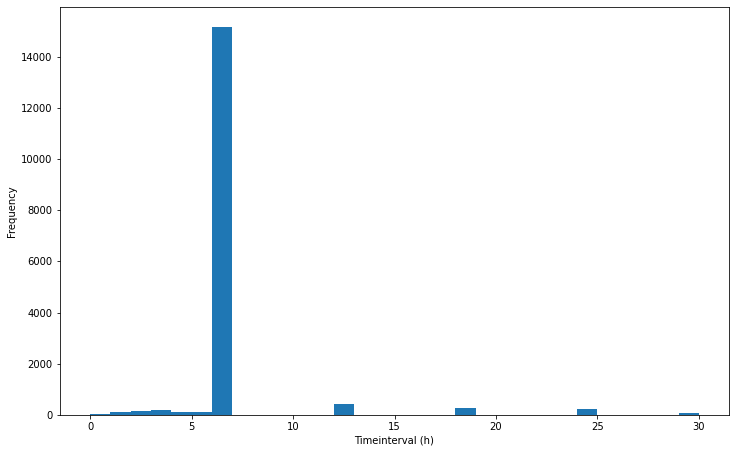

In [7]:
# Plotting time intervals between records
hurricanes_grouped = hurricanes.groupby("ID")
res = []

for name, group in hurricanes_grouped:
   delta_t = (group["Datetime"]-group["Datetime"].shift()).iloc[1:]
   res.append(delta_t)

res = [item for sublist in res for item in sublist]
res = [x/pd.Timedelta(minutes=60) for x in res]

plt.hist(res, bins=30, range=(0,30))
plt.ylabel('Frequency')
plt.xlabel('Timeinterval (h)');

<div style="text-align: justify">As the frequency plot of the time intervals between two recordings shows, the data set has regular 6h intervals between the recording times in the vast majority of cases. These result from the recordings at the synoptic times 0, 6, 12, 18 o'clock. The few cases with smaller intervals correspond to the entries that record specific events. Therefore, in addition to the variable already excluded, the associated irregularly recorded values are now also excluded.</div>

In [8]:
# remove all entries not corresponding to the synoptic times 00,06,12,18
syn_times_idx = [dt.strftime("%H%M") in ["0000", "0600", "1200", "1800"] for dt in hurricanes["Datetime"]]
hurricanes = hurricanes[syn_times_idx]

<div style="text-align: justify">Longer time intervals are multiples of 6h and indicate individual time gaps in the recording of the variables. It can be assumed that these gaps exist especially for observations at the beginning of the period under consideration (from 1950 onwards), as e.g. instrument failures are more likely here. This hypothesis is examined in more detail below by plotting the proportion of time intervals greater than 6 hours in all time intervals for all hurricanes in a 5-year period.</div>

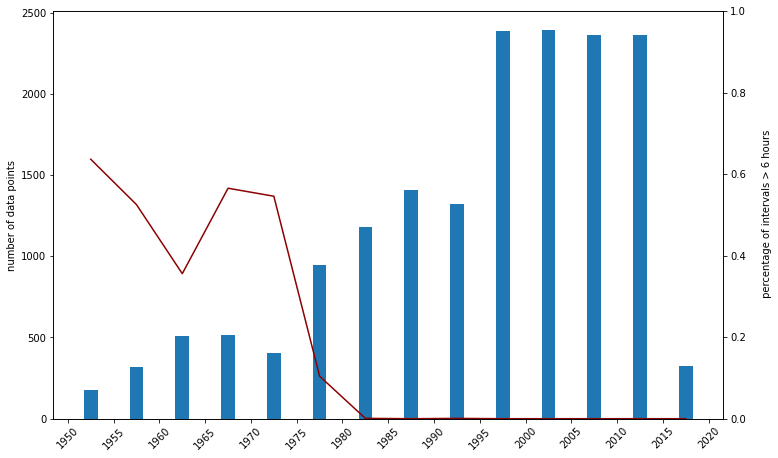

In [9]:
# analyse temporal patterns in interval times
hurricanes_grouped = hurricanes.groupby("ID")
hurricanes["Time interval"] = hurricanes_grouped["Datetime"].transform(lambda x: x - x.shift())
_hurricanes = hurricanes.dropna(subset=["Time interval"])

# plotting time intervals between records
hurricanes_grouped = _hurricanes.groupby([x for x in 5 * np.floor(_hurricanes["Year"]/5)])
hurricanes_vis = pd.DataFrame({
    "n_data_points" : hurricanes_grouped["ID"].count(),
    "p_long_intervals" : hurricanes_grouped["Time interval"].agg(lambda x: sum(x != pd.Timedelta(hours=6))/len(x)) 
})

fig, ax1 = plt.subplots()
# plotting number of data points on left axis
ax1.bar(hurricanes_vis.index, "n_data_points", data = hurricanes_vis, width = 1.5)
ax1.set_ylabel("number of data points")
ax1.set_xticks(ticks = [*[x-2.5 for x in hurricanes_vis.index], hurricanes_vis.index[-1]+2.5],
               labels = [int(x) for x in [*hurricanes_vis.index,  hurricanes_vis.index[-1]+5]],
               rotation = 45)
ax1.set_ylim(0)
# plotting percentage of 6 hour intervals on right axis
ax2 = ax1.twinx()
ax2.plot(hurricanes_vis.index, hurricanes_vis.p_long_intervals, color="darkred")
ax2.set_ylabel("\n percentage of intervals > 6 hours")
ax2.set_ylim(0, 1);

<div style="text-align: justify">The figure shows that almost all data gaps are limited to the period 1950 to 1980. Since then there have been continuous records at 6h intervals. Since the amount of data points before 1980 also shown is small, subsequent analyses can be limited to the period from 1980 onwards without further problems. After removing the few hurricane tracks with still existing irregularities in the time intervals in the period from 1980 onwards, there is thus a data set which exclusively shows equal time intervals.</div>

In [10]:
# keep only records from 1980 onwards & remove later ones with gaps larger than 6 hours
hurricanes = hurricanes[hurricanes["Datetime"] > datetime.strptime("19800101", "%Y%d%m")]
rm_ids = hurricanes[[x > pd.Timedelta(hours=6) for x in hurricanes["Time interval"]]]["ID"]
hurricanes = hurricanes[~hurricanes["ID"].isin(rm_ids)]
print(f"{len(rm_ids)} hurricane tracks removed due to time gaps larger than 6 hours")

2 hurricane tracks removed due to time gaps larger than 6 hours


<div style="text-align: justify">For the representation of the spatial component, interactive map representations are used in the following. This allows for fast, flexible and multivariate visualisations of patterns in the data. Note that the visualisation and interactivity of the widgets is lost in the rendered HTML format of this notebook. Some key findings from the spatial visualisation are therefore presented below as static figures and briefly described.</div>

In [11]:
# interactive plotting of trajectories

warnings.filterwarnings("ignore")

# create user interface inputs
years = widgets.IntRangeSlider(
    value=[1900, 2100],
    min=min([x.year for x in hurricanes["Datetime"]]),
    max=max([x.year for x in hurricanes["Datetime"]]),
    step=1,
    description='Years (inclusive):',
    style = {'description_width': 'initial'},
    layout=Layout(width='50%')
)

months_dt = [datetime.strptime(str(i), "%m") for i in range(1,13)]
options = [(i.strftime('%b'), i) for i in months_dt]
months = widgets.SelectionRangeSlider(
    options=options,
    index=(0,11),
    description='Months (inclusive):',
    style = {'description_width': 'initial'},
    layout=Layout(width='40%')
)

hurricane_ids = list(hurricanes.ID.unique())

id_select = widgets.SelectMultiple(
    options=hurricane_ids,
    value=hurricane_ids,
    description='Id select:',
    rows=10,
    style = {'description_width': 'initial'}
)

popup_vars = widgets.SelectMultiple(
    options=list(hurricanes.select_dtypes(exclude=['datetime', 'timedelta']).columns),
    value=["Maximum Wind", "Minimum Pressure"],
    description='Popup variables:',
    rows=10,
    style = {'description_width': 'initial'}
)

numeric_vars = list(hurricanes.select_dtypes(include=['number']).columns)
numeric_vars.insert(0,None)
categorial_vars = list(hurricanes.select_dtypes(include=['object']).columns)

size_var = widgets.Dropdown(
    options=numeric_vars,
    description='Marker size:',
    style = {'description_width': 'initial'}
)

color_var_numerical = widgets.Dropdown(
    options=numeric_vars,
    description='Marker color 1st map:',
    value="Maximum Wind",
    style = {'description_width': 'initial'}
)

color_var_categorial = widgets.Dropdown(
    options=categorial_vars,
    description='Marker color 2nd map:',
    value="Name",
    style = {'description_width': 'initial'}
)

basemap = widgets.RadioButtons(
    options=['osm_base', 'osm_topographic'],
    value='osm_base'
)

out_info = widgets.Output()

# create function to define two interlinked maps with their initial settings
# two maps only differ in their vis settings w.r.t. marker color
# two maps need to be defined due to different layer stack composition (numeric vs. categorial vis var)
def hurrican_map(color_var):
    fig = go.FigureWidget(data = px.scatter_mapbox(
        data_frame = hurricanes,
        lat="Latitude",
        lon="Longitude",
        color=color_var,
        hover_data={"Latitude": False, 
                    "Longitude": False, 
                    "Maximum Wind": True,
                    "Minimum Pressure": True},
        width=975,
        height=700,
        center=go.layout.mapbox.Center(lat=47.5, lon=-60),
        zoom=1.75))
    fig = fig.update_layout(mapbox_style="open-street-map")
    return fig

map_I = hurrican_map("Maximum Wind")
if 'google.colab' not in str(get_ipython()):
    map_II = hurrican_map("Name")

# define update (backend) procedures
class map_update:
    # initialisation procedure - set df & map to apply updates
    def __init__(self, map):
        self.df = hurricanes
        self.map = map

    def df_update(self):
        # get selection of years
        start_year = str(years.value[0]) + "0101"
        end_year = str(years.value[1]+1) + "0101"
        # get selection of months
        start_month = months.value[0].month
        end_month = months.value[1].month+1
        # apply temporal subsetting      
        self.df = self.df[self.df["Datetime"].between(datetime.strptime(start_year, "%Y%d%m"), 
                                                      datetime.strptime(end_year, "%Y%d%m"))]
        self.df = self.df[[x.month in range(start_month, end_month) for x in self.df["Datetime"]]]
        # apply id subsetting 
        self.df = self.df[[x in id_select.value for x in self.df["ID"]]]

    def map_vis_update(self, color_var):
        # clear previous outputs
        out_info.clear_output()
        # get columns to display in popups
        hover_vars = {}
        for col in list(self.df.select_dtypes(exclude=['datetime', 'timedelta']).columns):
            if col in popup_vars.value:
                hover_vars[col] = True
            else:
                hover_vars[col] = False
        # get size var
        if size_var.value != None:
            marker_size_var = size_var.value
        else:
            marker_size_var = None
        # configure fig based on selection
        if len(self.df) != 0:
            self.map_new = go.FigureWidget(data = px.scatter_mapbox(
                data_frame = self.df,
                lat="Latitude",
                lon="Longitude",
                size = marker_size_var,
                color = color_var.value,
                hover_data=hover_vars))
            self.map_new = self.map_new.update_layout(
                {'coloraxis': {'colorbar': {'title': {'text': color_var.value}}}}
                )
        else:
            with out_info:
                print("Selection obtained no data points. No map update was done. Reload of widget necessary!")
        # update basemap
        if basemap.value == "osm_base":
            self.map_new = self.map_new.update_layout(
            mapbox_style="open-street-map",
            mapbox_layers=[
                {
                    "below": 'traces',
                    "sourcetype": "raster",
                    "sourceattribution": "© OpenStreetMap contributors",
                    "source": [
                        "https://tile.openstreetmap.org/{z}/{x}/{y}.png"
                    ]
                }
            ])
        else:
            self.map_new = self.map_new.update_layout(
            mapbox_style="white-bg",
            mapbox_layers=[
                {
                    "below": 'traces',
                    "sourcetype": "raster",
                    "sourceattribution": "© OpenStreetMap contributors",
                    "source": [
                        "https://tile.opentopomap.org/{z}/{x}/{y}.png"
                    ]
                }
            ])
        # update old map using new properties
        self.map.update(data = self.map_new.data,
                            layout = {'coloraxis': self.map_new.layout.coloraxis,
                                    'mapbox': {'layers': self.map_new.layout.mapbox.layers,
                                                'style': self.map_new.layout.mapbox.style}})
        if 'google.colab' in str(get_ipython()):
            clear_output(wait=True)
            print("\n\033[1mTemporal Subsetting\n")
            display(widgets.VBox([years, months]))
            print("\n\033[1mID Subsetting\n")
            display(id_select)
            print("\n\033[1mVisualisation Settings\n")
            display(widgets.HBox([widgets.VBox([popup_vars], layout=Layout(padding='0px 25px 0px 0px')), widgets.VBox([size_var, color_var_numerical])]))
            print("\n\033[1mBasemap Settings\n")
            display(basemap)
            self.map.show(renderer="colab")
                
def response_map_I(change):
    map_I_updater = map_update(map_I)
    map_I_updater.df_update()
    map_I_updater.map_vis_update(color_var_numerical)

def response_map_II(change):
    map_II_updater = map_update(map_II)
    map_II_updater.df_update()
    map_II_updater.map_vis_update(color_var_categorial)
                                    
# observe changes
if 'google.colab' in str(get_ipython()):
    response_funcs = [response_map_I]
else:
    response_funcs = [response_map_I, response_map_II]
    color_var_categorial.observe(response_map_II, names="value")

color_var_numerical.observe(response_map_I, names="value")

for response in response_funcs:
    years.observe(response, names="value")
    months.observe(response, names="value")
    id_select.observe(response, names="value")
    popup_vars.observe(response, names="value")
    size_var.observe(response, names="value")
    basemap.observe(response, names="value")

# configure layout & display figure
if 'google.colab' in str(get_ipython()):
    print("\n\033[1mTemporal Subsetting\n")
    display(widgets.VBox([years, months]))
    print("\n\033[1mID Subsetting\n")
    display(id_select)
    print("\n\033[1mVisualisation Settings\n")
    display(widgets.HBox([widgets.VBox([popup_vars], layout=Layout(padding='0px 25px 0px 0px')), widgets.VBox([size_var, color_var_numerical, color_var_categorial])]))
    print("\n\033[1mBasemap Settings\n")
    display(basemap)
    map_I.show(renderer="colab")
else:
    accordion = widgets.Accordion([widgets.VBox([years, months]),
                                widgets.VBox([id_select]),
                                widgets.HBox([widgets.VBox([popup_vars], layout=Layout(padding='0px 25px 0px 0px')),
                                                widgets.VBox([size_var, color_var_numerical])]),
                                basemap])
    accordion.set_title(0, 'Temporal Subsetting')
    accordion.set_title(1, 'ID Subsetting')
    accordion.set_title(2, 'Visualisation Settings')
    accordion.set_title(3, 'Basemap Settings')
    widgets.VBox([accordion, out_info, map_I, map_II])

<div style="text-align: justify">First of all, it should be noted that the spatial representation shows the elimination of some of the irregularities and errors in the data described at the beginning. For example, there are no longer any unusual locations, so the corresponding erroneous longitude data was obviously eliminated by filtering out older hurricanes.</div>

In [ ]:
# reset warnings to default
warnings.filterwarnings("default")

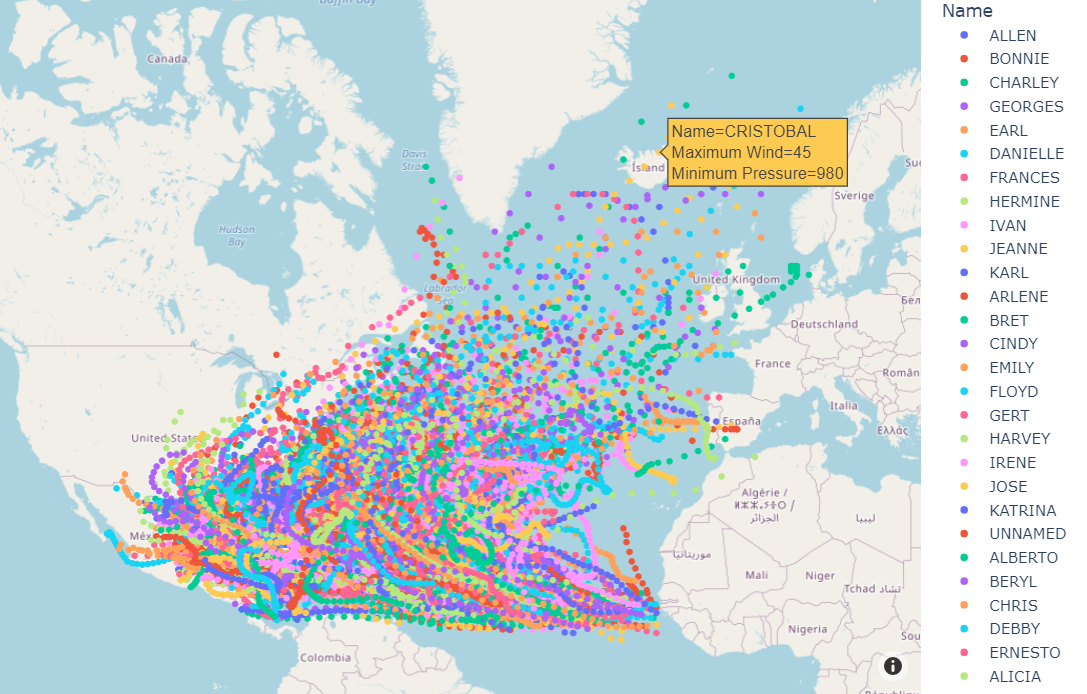

In [12]:
Image(os.path.join(os.pardir,'docs', 'map_all.png'), width=500)


<div style="text-align: justify">In general, the usual migration pattern of hurricanes in the Atlantic Ocean is clearly visible. Starting from a point of origin near the equator, most hurricanes initially move northwest following uniform wind conditions over a large area. At the height of the northern tropic, they then turn around and move mostly towards the northeast, where they gradually weaken due to a lack of further energy from increasingly colder air masses (NOAA 2021a). A seasonal representation of hurricane tracks shows that this simplified pattern applies to the majority of hurricanes in summer to late summer. The few hurricanes outside the classic hurricane period, on the other hand, usually show more complex and less uniform movement patterns.</div>

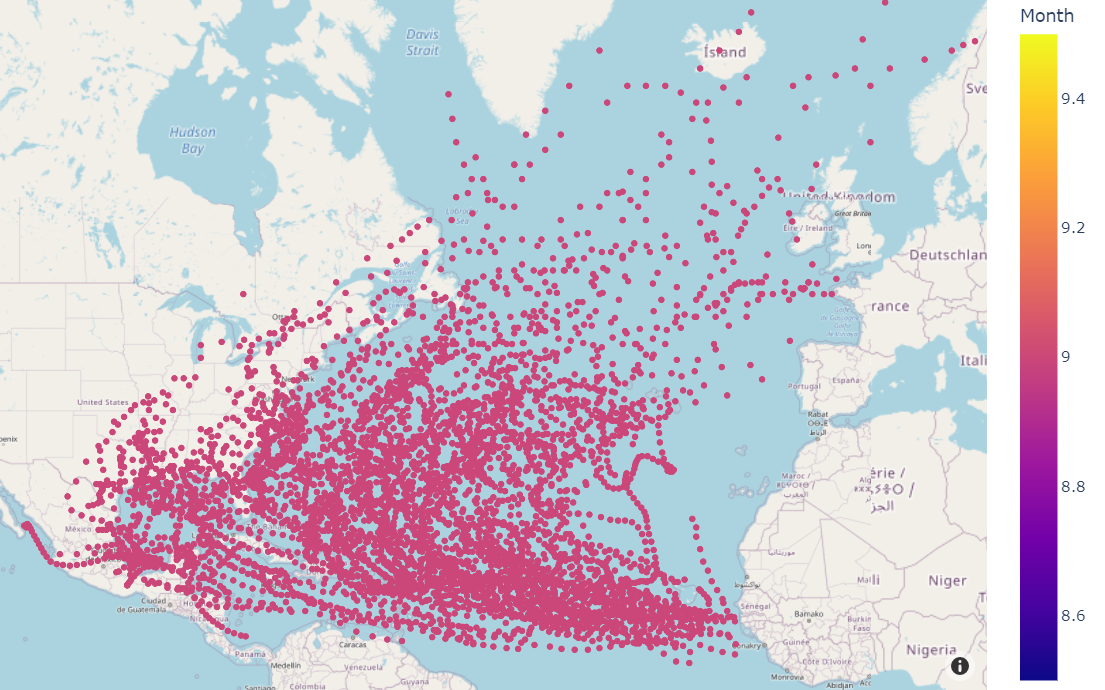

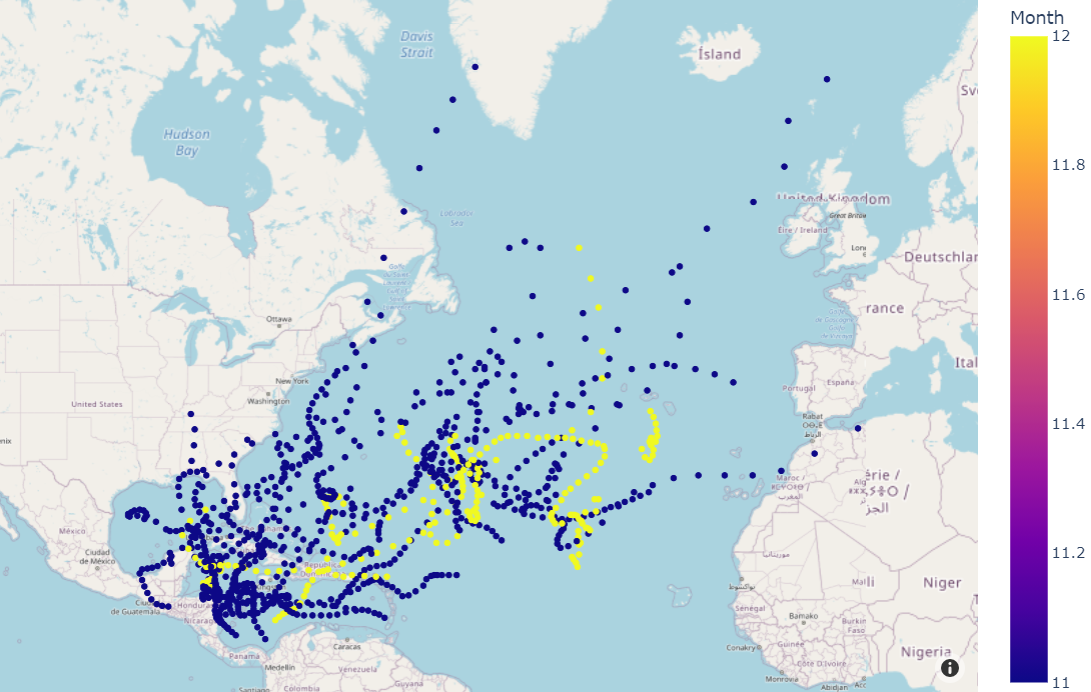

In [13]:
Image(os.path.join(os.pardir,'docs', "map_high_season.png"), width=500)
Image(os.path.join(os.pardir,'docs', "map_late_season.png"), width=500)

<div style="text-align: justify">The weakening of a hurricane occurs very intensively in the case of a landfall. The lack of latent energy through maritime air masses then becomes clearly noticeable. Accordingly, there is a clear intensity gradient (in terms of wind speed) for hurricanes at the land-water boundary. More important with regard to the question of the next position of a hurricane, however, is the concentration of hurricanes in the coastal area, evident in the following map in the Mexican Gulf and off the east coast of Florida. Relatively few hurricanes reach the mainland, which may be due to a change in the direction of migration or slowing down and dissipation during or shortly before a potential landfall. While the connection between hurricane intensity and continentality is clearly evident, the dependency between directional changes and proximity to the coast can only be assumed here for the time being, but gives rise to further investigations in the context of feature engineering.</div>

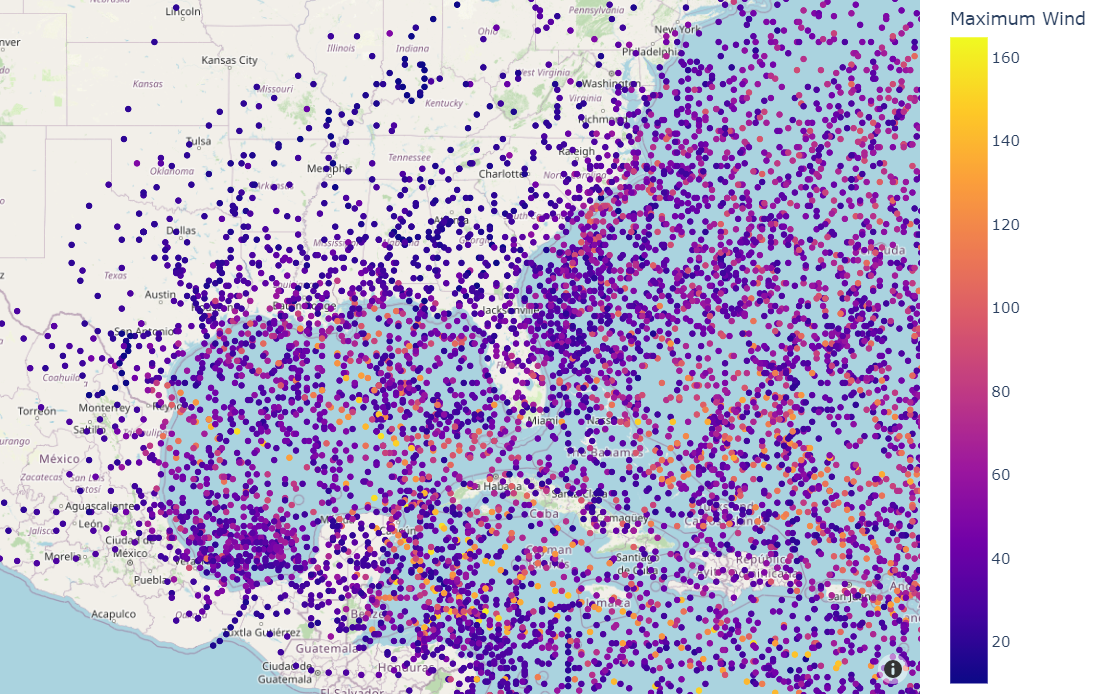

In [14]:
Image(os.path.join(os.pardir,'docs', 'map_land_sea_contrast.png'), width=500)

<div style="text-align: justify">The use of a topographic basemap finally makes it possible to analyse the extent to which hurricane movements are controlled by the relief on land. Enhanced topography seems to contribute to the general weakening of hurricanes so that relatively few hurricanes reach these areas. However, for these hurricanes that cross barriers such as the Rocky Mountains, Appalachians or the mountainous areas of the Dominican Republic, no clear relief-induced movement changes can be observed. It is not evident that the distance travelled within 6h is significantly reduced in such mountainous areas, nor that there is a clear reversal of direction just before reaching the mountains. Accordingly, the topography is not further included as a relevant feature.</div>

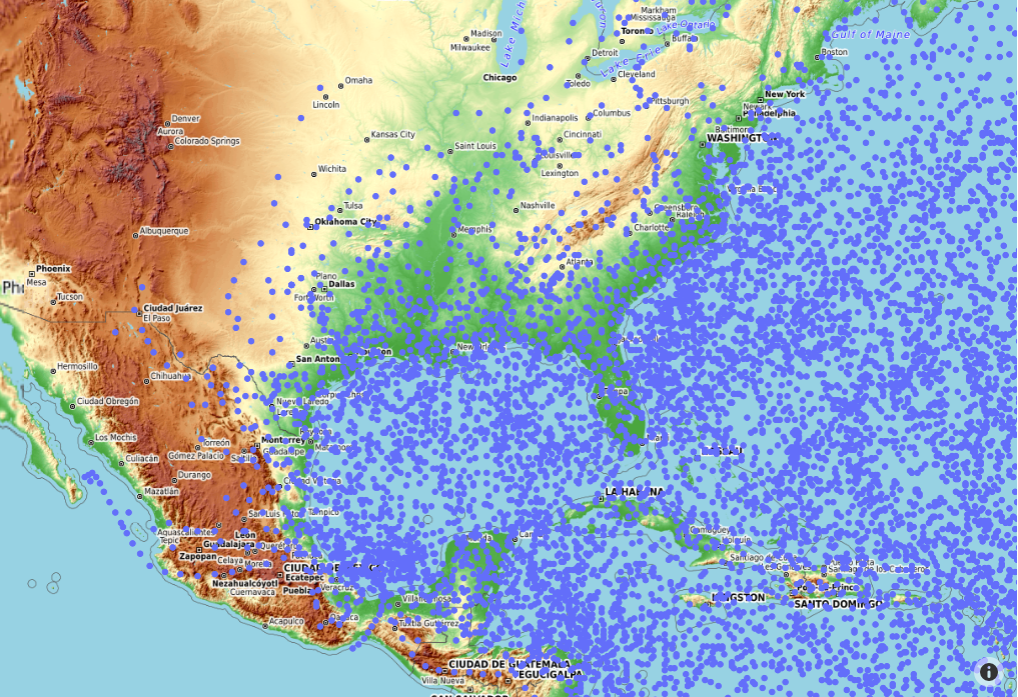

In [15]:
Image(os.path.join(os.pardir,'docs', 'map_topography.png'), width=500)

### Feature engineering
#### Feature creation

<div style="text-align: justify"></br>The next step is to derive features from the data. The selection and engineering of features that are actually useful for the prediction problem at hand is based on the exploratory data analysis above and some basic knowledge about the influencing factors on hurricane movements.</br>
Given the recent records of the hurricanes movement, there are two fundamental questions to be answered. Regarding both of them, it should be noted upfront that the application of more complex deep learning models makes parts of the following considerations obsolete and that the recognition of patterns in the data set would also be possible without the feature engineering approaches mentioned. However, since more traditional ML approaches will be applied, the following considerations are made:</br>
The first fundamental question is whether to directly predict the next position of a hurricane as a pair of latitude/longitude values or calculating their changes to predict the changes of latitude/longitude values. In this regard, the later option clearly seems to be superior to the first one as this allows to make use of the pattern detection abilities of machine learning algorithms. Although the database is already large, the approach to directly predict lat/lon values would require many more hurricane tracks as the variability of absolute lat/lon is pretty high.</br>
Connected to this question, however, is the more ambiguous question of the extent to which it makes sense at all to frame the problem as a prediction of lat/long changes. The alternative of switching from cartesian coordinates to polar coordinates and thus arriving at the next position via the prediction of the direction (bearing) and distance may be more favourable. Assuming that distance and direction are two variables that can be more clearly separated from each other, each with their own influencing factors, this engineering approach promises to deliver accurate results even with simpler models. Pattern recognition in the variables lat/long changes, which may be related in more complex ways, can thus be circumvented to some extent. However, this only applies to a limited extent, since the prediction of the direction in the final implementation requires a retransformation to cartesian coordinates. This follows from the fundamental problem of predicting angles in degrees, since these are not differentiable, i.e. they have a jump from 359 to 0 degrees. Although the difference between 350 and 0 degrees is only 10 degrees, after mathematical subtraction it is 350 degrees implying distortions in ML models. A possible way to deal with this would be to perform a binning by one-hot-encoding of the angles and predict these categorical variables (classification). However, the retransformation to cartesian coordinates and thus a regression of the sinusoidal and cosinusoidal part of the angle seems generally superior to this (StatsExchange 2017) and is therefore also applied below.</div>

Briefly summarised: The prediction problem is considered in the following as a regression of three variables - the distance, the sine component and the cosine component of the angle - which are finally combined again to specify the position in lat/long.

The following features are created by segmenting the hurricane tracks into smaller sections:
* distances covered for the four 6h intervals before the last recording
* directions/bearings also for the last four 6h-intervals - specified as sin/cos shares
* variability of distances and directions for the entire available history of a hurricane
* total number of records for a hurricane so far

<div style="text-align: justify">The upper two feature groups are particularly essential. The 24h period is considered to be a meaningful period for getting the current values and possibly existing trends for the movement of the hurricane. Shorter periods may be too susceptible to short term fluctuations in distances and directions, longer periods on the other hand reduce the effectively available amount of data points and and increase the amount of strongly correlated features. The latter would definitely have a negative impact on the performance, but possibly also on the accuracy of the models. Capturing the variability of distances and directions for the overall course of the hurricane, however, is an attempt to compress the essence of all information on the hurricane's movement going back further than 24 hours into two features. The basic assumption is that the more distant history of hurricanes may well offer added information value complementing the short-term history, since hurricane movements are essentially dependent on large-scale lateral atmospheric conditions. A generally stronger/weaker development of the trade winds, for example, characterises the state of the atmosphere clearly beyond the movement radius of a hurricane within 24 hours, so that there is significance for the future development of a hurricane despite possibly different small-scale conditions for a short time. The extent to which these features can actually be put to use will be evaluated in the further course by testing various feature sets with and without the inclusion of these speculative features. The same applies to the feature that describes the number of records so far and is intended to characterise the maturity of the hurricane system independently of its concrete position.</div>

In [16]:
# feature engineering part I

hurricanes_grouped = hurricanes.reset_index(level=0).groupby("ID")
features = []

for name, group in hurricanes_grouped:
    group["lat_lon"] = list(zip(group["Latitude"], group["Longitude"]))
    geom_features = list(map(lambda coord_1, coord_2: 
                             Geodesic.WGS84.Inverse(coord_1[0], coord_1[1], coord_2[0], coord_2[1]), 
                             group["lat_lon"].shift().iloc[1:], group["lat_lon"].iloc[1:]))
    # distance calculations
    distances = [x["s12"]/1000 for x in geom_features]
    dist_vars = {}
    # next Distance as var to be explained later on
    dist_vars["Next Distance"] = [*[x["s12"]/1000 for x in geom_features], np.nan]
    # previous Distances as explaining vars
    for time_step in range(1,5):
        trailing_nans = time_step*[np.nan]
        shifted_dists = [x["s12"]/1000 for x in geom_features][:(len(geom_features)-(time_step-1))]
        dist_vars[f"Prev. Distance {(time_step-1)*6}-{time_step*6}h"] = [*trailing_nans, *shifted_dists]
    ### --- equivalent to, but faster than --- ###
    # for time_step in range(1,5):
    #     shifted_dists = pd.DataFrame(dist_vars["Next Distance"]).transform(lambda x: x.shift(time_step))
    #     dist_vars[f"Prev. Distance {(time_step-1)*6}-{time_step*6}h"] = shifted_dists.loc[:,0].tolist()
    ### --- equivalent to, but faster than --- ###
    # distance variability as global feature to characterise whole path so far
    std = pd.DataFrame(distances).rolling(len(distances), min_periods=2).std()
    mean = pd.DataFrame(distances).rolling(len(distances), min_periods=2).mean()
    dist_vars["Distance Varcoeff"] = [np.nan, *(std/mean).iloc[:,0].tolist()]
    # bearing calculations
    bearings = [x["azi1"] for x in geom_features]
    for idx, dist in enumerate(distances):
        if dist == 0:
            bearings[idx] = np.nan
    bearings = pd.Series(bearings).interpolate("nearest").tolist()
    bearing_vars = {}
    # next Bearing as var to be explained later on
    bearing_vars["Next Bearing"] = [*bearings, np.nan]
    bearing_vars["Next Bearing cos"] = np.cos(np.radians([*bearings, np.nan]))
    bearing_vars["Next Bearing sin"] = np.sin(np.radians([*bearings, np.nan]))
    # previous Bearings as explaining vars
    for time_step in range(1,5):
        trailing_nans = time_step*[np.nan]
        shifted_dists = bearings[:(len(geom_features)-(time_step-1))]
        bearing_vars[f"Prev. Bearing {(time_step-1)*6}-{time_step*6}h"] = [*trailing_nans, *shifted_dists]
        bearing_vars[f"Prev. Bearing {(time_step-1)*6}-{time_step*6}h cos"] = np.cos(np.radians(bearing_vars[f"Prev. Bearing {(time_step-1)*6}-{time_step*6}h"]))
        bearing_vars[f"Prev. Bearing {(time_step-1)*6}-{time_step*6}h sin"] = np.sin(np.radians(bearing_vars[f"Prev. Bearing {(time_step-1)*6}-{time_step*6}h"]))
    # bearing variability as global feature to characterise whole path so far
    angle_diffs = pd.DataFrame(bearing_vars["Prev. Bearing 0-6h"]).rolling(2).apply(lambda x: ((x.iloc[1]- x.iloc[0]) + 180) % 360 - 180)
    bearing_vars["Bearing Abs Std"] = angle_diffs.abs().rolling(len(angle_diffs), min_periods=2).std().iloc[:,0].tolist()
    # append features for each timestep to overall df
    for idx, _ in enumerate(group["ID"]):
        single_features = {}
        # note that operations on groups via loop require index tracking
        # otherwise later concating will not match both dfs appropriately
        single_features["index"] = group["index"].iloc[idx]
        single_features["Timestep"] = idx
        for key, item in dist_vars.items():
            single_features[key] = item[idx]
        for key, item in bearing_vars.items():
            single_features[key] = item[idx]
        features.append(single_features)

hurricanes_features = pd.merge(hurricanes.reset_index(level=0), pd.DataFrame(features), on="index")

<div style="text-align: justify">In addition, based on the above findings on the potential importance of the location of the hurricane over the open sea vs. the coastal area and the mainland, a feature is designed which describes the distance of the last location to the coast in km. The distance to the coast in the direction of the last movement of the hurricane is determined at a granularity of 25km. This granularity is on the one hand considered to be sufficiently precise to capture a potential influence of the land when a hurricane approaches and on the other hand keeps the computational effort for this feature within limits.</div>

In [17]:
# feature engineering part II

def continent_dist(idx, lat, lon, bearing):
    # side note on imports:
    # on Linux, when you start a child process, it is forked, 
    # i.e. the child process inherits the memory state of the parent process
    # on Windows, however, processes are spawned, i.e. a new interpreter starts and the code reruns
    from geographiclib.geodesic import Geodesic
    from shapely.geometry import Point
    import geopandas as gpd
    # definition of continent geometry
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    # create continent multipolygon
    continents_geoms = world.dissolve().iloc[0].geometry
    # procedure to determine distances to continents
    dist = 0
    single_point = {}
    single_point["index"] = idx
    while dist <= 500:
        point_geom = Geodesic.WGS84.Direct(lat, lon, bearing, 1000*dist)
        if Point(point_geom["lon2"], point_geom["lat2"]).within(continents_geoms):
            single_point["Continent Distance"] = dist
            break
        elif dist == 500:
            single_point["Continent Distance"] = 500
            break
        else:
            dist += 25
    return single_point

# multiprocessing.Pool stuck indefinitely, thus using multiprocess which works with jupyter notebooks
with multiprocess.Pool(processes=os.cpu_count()) as pool:
    params = zip(hurricanes_features.dropna(subset=["Next Bearing"])["index"],
                 hurricanes_features.dropna(subset=["Next Bearing"])["Latitude"],
                 hurricanes_features.dropna(subset=["Next Bearing"])["Longitude"],
                 hurricanes_features.dropna(subset=["Next Bearing"])["Next Bearing"])
    dist_to_continent = pool.starmap(continent_dist, params)

hurricanes_features = pd.merge(hurricanes_features, pd.DataFrame(dist_to_continent), on="index")
hurricanes_features.dropna(inplace=True)

In [18]:
# display feature df so far
hurricanes_features

index        ID   Name            Datetime    Year  Month   Day  Hour  \
4      33708  AL041980  ALLEN 1980-08-02 00:00:00  1980.0    8.0   2.0   0.0   
5      33709  AL041980  ALLEN 1980-08-02 06:00:00  1980.0    8.0   2.0   6.0   
6      33710  AL041980  ALLEN 1980-08-02 12:00:00  1980.0    8.0   2.0  12.0   
7      33711  AL041980  ALLEN 1980-08-02 18:00:00  1980.0    8.0   2.0  18.0   
8      33712  AL041980  ALLEN 1980-08-03 00:00:00  1980.0    8.0   3.0   0.0   
...      ...       ...    ...                 ...     ...    ...   ...   ...   
13649  49099  AL122015   KATE 2015-11-12 06:00:00  2015.0   11.0  12.0   6.0   
13650  49100  AL122015   KATE 2015-11-12 12:00:00  2015.0   11.0  12.0  12.0   
13651  49101  AL122015   KATE 2015-11-12 18:00:00  2015.0   11.0  12.0  18.0   
13652  49102  AL122015   KATE 2015-11-13 00:00:00  2015.0   11.0  13.0   0.0   
13653  49103  AL122015   KATE 2015-11-13 06:00:00  2015.0   11.0  13.0   6.0   

      Status  Latitude  Longitude  Maximum Wind  Minimum Pressure  \
4         TS      11.0      -42.8          35.0            1005.0   
5         TS      11.4      -44.8          45.0            1000.0   
6         TS      11.9      -46.9          55.0             995.0   
7         TS      12.3      -49.1          60.0             990.0   
8         HU      12.4      -51.4          65.0             985.0   
...      ...       ...        ...           ...               ...   
13649     EX      40.0      -52.0          65.0             980.0   
13650     EX      41.3      -50.4          55.0             981.0   
13651     EX      41.9      -49.9          55.0             983.0   
13652     EX      41.5      -49.2          50.0             985.0   
13653     EX      40.8      -47.5          45.0             985.0   

        Time interval  Timestep  Next Distance  Prev. Distance 0-6h  \
4     0 days 06:00:00         4        222.862              232.004   
5     0 days 06:00:00         5        235.570              222.862   
6     0 days 06:00:00         6        243.549              235.570   
7     0 days 06:00:00         7        250.392              243.549   
8     0 days 06:00:00         8        240.156              250.392   
...               ...       ...            ...                  ...   
13649 0 days 06:00:00        14        197.864              285.627   
13650 0 days 06:00:00        15         78.602              197.864   
13651 0 days 06:00:00        16         73.272               78.602   
13652 0 days 06:00:00        17        162.501               73.272   
13653 0 days 06:00:00        18        177.693              162.501   

       Prev. Distance 6-12h  Prev. Distance 12-18h  Prev. Distance 18-24h  \
4                   229.732                240.672                229.961   
5                   232.004                229.732                240.672   
6                   222.862                232.004                229.732   
7                   235.570                222.862                232.004   
8                   243.549                235.570                222.862   
...                     ...                    ...                    ...   
13649               315.064                413.492                474.653   
13650               285.627                315.064                413.492   
13651               197.864                285.627                315.064   
13652                78.602                197.864                285.627   
13653                73.272                 78.602                197.864   

       Distance Varcoeff  Next Bearing  Next Bearing cos  Next Bearing sin  \
4                  0.022       -78.356             0.202            -0.979   
5                  0.028       -76.210             0.238            -0.971   
6                  0.026       -79.303             0.186            -0.983   
7                  0.030       -87.222             0.048            -0.999   
8                  0.038       -84.476           

#### Feature evaluation & selection

In [19]:
mean_dist = int(round(hurricanes_features["Next Distance"].mean(),0))
max_speed = int(hurricanes_features.nlargest(1, "Next Distance")["Next Distance"]/6)

<div style="text-align: justify">In the following, some excerpts from the analyses of the new features are presented, which on the one hand serve to confirm the resilience of the cleaned data set and on the other hand are intended to give a first idea of the usefulness of the features for the later models.</br>
The following shows the frequency distribution of the distances travelled within the 6h intervals. With an average distance of about {{a}}km, the average speed of a hurricane is about {{mean_dist/6}}km/h, which in good agreement with literature values again speaks for the validity of the data set.</div>

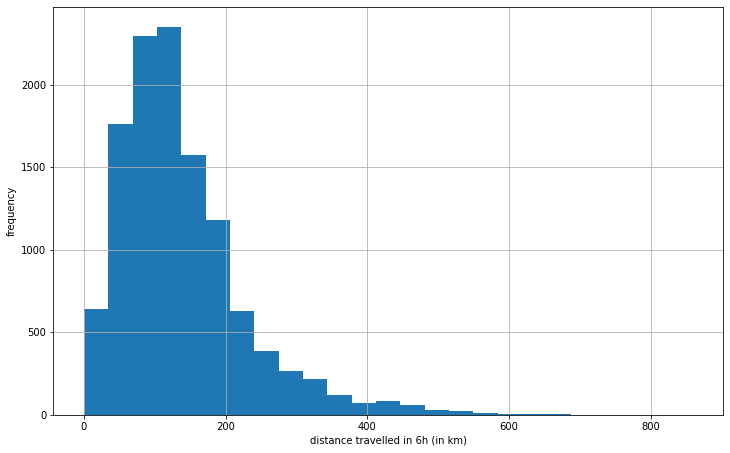

In [20]:
hurricanes_features.hist("Next Distance", bins=25)
plt.title('')
plt.xlabel('distance travelled in 6h (in km)')
plt.ylabel('frequency');

<div style="text-align: justify">As a further check on data quality, the hurricanes with the five largest distances travelled within 6h are shown below. A comparison with the documentation of these hurricanes from other sources again shows that the data are error-free despite very high speeds of up to {{max_speed }}km/h.</div>

In [21]:
# check potentially suspiciously large distances
hurricanes_features.sort_values("Next Distance", ascending=False).head(5)

index        ID     Name            Datetime    Year  Month   Day  Hour  \
6133  41061  AL131999    IRENE 1999-10-19 00:00:00  1999.0   10.0  19.0   0.0   
5685  40582  AL121998     LISA 1998-10-09 18:00:00  1998.0   10.0   9.0  18.0   
3934  38739  AL031995  CHANTAL 1995-07-21 18:00:00  1995.0    7.0  21.0  18.0   
1834  36244  AL121987    EMILY 1987-09-26 12:00:00  1987.0    9.0  26.0  12.0   
1833  36243  AL121987    EMILY 1987-09-26 06:00:00  1987.0    9.0  26.0   6.0   

     Status  Latitude  Longitude  Maximum Wind  Minimum Pressure  \
6133     HU      41.5      -61.0          80.0             968.0   
5685     HU      47.1      -39.3          65.0             997.0   
3934     EX      53.0      -31.0          50.0            1005.0   
1834     HU      44.8      -42.5          65.0             983.0   
1833     HU      41.2      -49.0          70.0             979.0   

       Time interval  Timestep  Next Distance  Prev. Distance 0-6h  \
6133 0 days 06:00:00        26        858.820              610.973   
5685 0 days 06:00:00        19        765.899              613.019   
3934 0 days 06:00:00        39        753.974              447.015   
1834 0 days 06:00:00        26        680.209              663.619   
1833 0 days 06:00:00        25        663.619              625.695   

      Prev. Distance 6-12h  Prev. Distance 12-18h  Prev. Distance 18-24h  \
6133               442.732                393.820                255.582   
5685               537.348                432.755                373.731   
3934               376.797                345.891                376.215   
1834               625.695                557.964                514.713   
1833               557.964                514.713                405.267   

      Distance Varcoeff  Next Bearing  Next Bearing cos  Next Bearing sin  \
6133              0.887        60.730             0.489             0.872   
5685              0.757        40.763             0.757             0.653   
3934              0.640        68.445             0.367             0.930   
1834              0.623        44.350             0.715             0.699   
1833              0.580        50.778             0.632             0.775   

      Prev. Bearing 0-6h  Prev. Bearing 0-6h cos  Prev. Bearing 0-6h sin  \
6133              60.944                   0.486                   0.874   
5685              -4.268                   0.997                  -0.074   
3934              64.188                   0.435                   0.900   
1834              50.778                   0.632                   0.775   
1833              53.531                   0.594                   0.804   

      Prev. Bearing 6-12h  Prev. Bearing 6-12h cos  Prev. Bearing 6-12h sin  \
6133               55.256                    0.570                    0.822   
5685               -7.138                    0.992                   -0.124   
3934               58.122                    0.528                    0.849   
1834               53.531                    0.594                    0.804   
1833               51.914                    0.617                    0.787   

      Prev. Bearing 12-18h  Prev. Bearing 12-18h cos  \
6133                54.665                     0.578   
5685                -1.183                     1.000   
3934                48.652                     0.661   
1834                51.914                     0.617   
1833                54.672                     0.578   

      Prev. Bearing 12-18h sin  Prev. Bearing 18-24h  \
6133                     0.816                51.973   
5685                    -0.021                11.559   
3934                     0.751                45.903   
1834                     0.787                54.672   
1833                     0.816                52.126   

      Prev. Bearing 18-24h cos  Prev. Bearing 18-24h sin  Bearing Abs Std  \
6133                     0.616                     0.788           16.966   
5685     

<div style="text-align: justify">An explicit presentation of the value distribution for the directional components (sin/cos of bearing) is omitted below, but plausibility checks carried out here also indicate the reliability of the engineered data.</br>

With regard to the selection of features for the subsequent ML models, variables are first excluded which with a high degree of certainty have no influence on the hurricane movement. These include identifying variables (name, index, ID) as well as the status as a categorical variable that is already mapped by other variables (see above). To further reduce the feature sets, the following presentation of existing correlations between features and labels as well as among features is useful.</div>

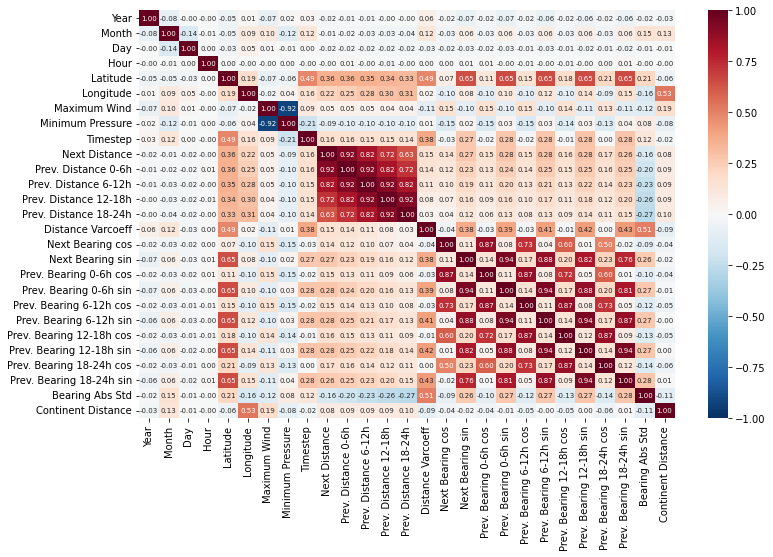

In [22]:
# select features & omit useless ones
drop_cols = ['index', 
             'ID', 
             'Name', 
             'Datetime', 
             'Status', 
             'Time interval',
             'Next Bearing', 
             'Prev. Bearing 0-6h', 
             'Prev. Bearing 6-12h', 
             'Prev. Bearing 12-18h', 
             'Prev. Bearing 18-24h']
hurricane_features_selected = hurricanes_features.drop(columns=drop_cols)

# plot correlation heatmap
sns.heatmap(hurricane_features_selected.corr(), cmap="RdBu_r", vmin=-1, vmax=1, annot=True, fmt=".2f", annot_kws={"size": 7});

In [23]:
corr_dist_varcoeff_dist_change = pd.DataFrame({"dev": abs(hurricanes_features["Prev. Distance 0-6h"] - hurricanes_features["Next Distance"]),
                                               "var": hurricanes_features["Distance Varcoeff"]}).corr()

corr_dist_varcoeff_dist_change = round(corr_dist_varcoeff_dist_change.iloc[0,1], 2)

The following patterns can be seen in the correlation matrix:
* The distance within the next 6 hours is very strongly positively correlated with the previous distances. As expected, the correlation strength decreases for distances further back in time. The strongest correlation is with the distance in the next 6h interval and amounts to r=0.92.
* A similar pattern emerges for the sine and cosine components of the direction. Again, there are strong correlations with the preceding interval values.
* Otherwise, none of the response variables show clear correlations with other features. An exception is latitude, which is correlated with the sine component of direction, which can be explained by the general movement pattern of many hurricanes with a rotation of the course from northwest to northeast. There is also a weak positive correlation between latitude and distance.
* Between the features themselves, there are otherwise clearly visible negative correlations between maximum wind and minimum pressure. This is consistent with the expectation that low pressures drive high wind speeds in a hurricane system.

<div style="text-align: justify">From these findings it can already be concluded that especially the engineered interval features based on the short-term history of the hurricanes will play an important role in the ML models. Conversely, this does not mean that all other features with low correlations to the response variables should be excluded. More complex non-linear relationships as well as the question of the multivariate interaction of variables cannot be described by the simple correlation matrix approach but can be represented in ML models. Only variables that are highly correlated with each other, such as minimum pressure and maximum wind, should not both be included. Therefore, only the maximum wind will be kept as a feature for the following models.</br> Although the actual suitability of the features not directly correlated with the response variables cannot be precisely determined a priori and, it is at least checked below to what extent the engineered features reflect the originally intended information content. The significance of the distance variance coefficient calculated over the complete history of a hurricane with regard to possible deviations of the next distance from the last distance, for example, must be doubted in view of the following weak correlation. Although the next distance tends to deviate more strongly from the previous one if all distances covered by the hurricane to date fluctuate strongly overall, the correlation is only weak (correlation coefficient r={{corr_dist_varcoeff_dist_change}}). In view of the fact that even with a strong correlation apart from the certainty about a change in distance, no further statement about the direction of the change in the sense of a decrease/increase would be possible, it can be assumed that the predictive power of this feature is low.</div>

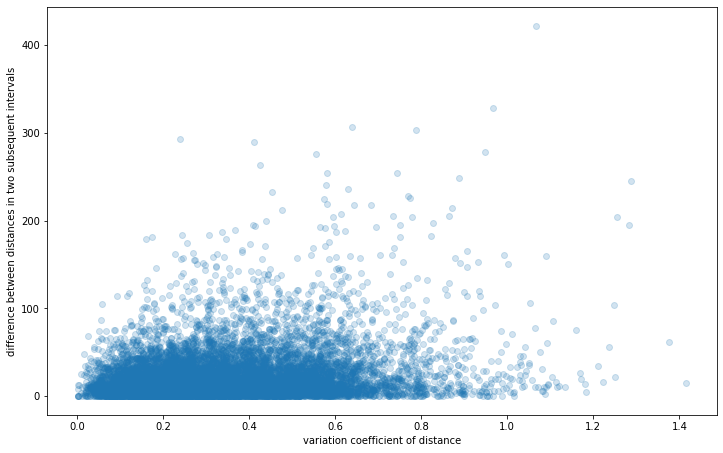

In [24]:
plt.scatter(hurricanes_features["Distance Varcoeff"], 
            abs(hurricanes_features["Next Distance"] - hurricanes_features["Prev. Distance 0-6h"]), 
            alpha = .2)
plt.xlabel('variation coefficient of distance')
plt.ylabel('difference between distances in two subsequent intervals');

<div style="text-align: justify">Expectations with regard to the performance of the continent distance feature for the prediction of the next distance must be formulated in a similarly cautious manner. As the following figure shows, the mean distance travelled on the coast and on the mainland is somewhat less than on the open sea, but this only applies within tropical and subtropical latitudes. In the midlatitudes north of 35 degrees, this relationship no longer applies and the hurricanes in the coastal area travel the greatest distances on average. Apart from that, the following figure again illustrates the relationship between latitude and distance, although here a non-linear relationship is to be assumed, as the distance travelled only increases significantly from 35 degrees north.</div>

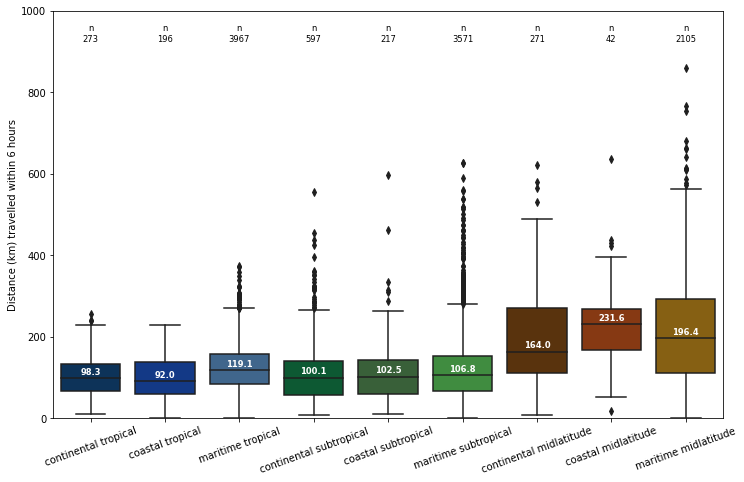

In [25]:
hurricanes_grouped = hurricanes_features.groupby("ID")
_hurricanes = hurricanes_features
# calculate distance for next 6 hours as variable to be predicted
_hurricanes["Distance Shifted"] = hurricanes_grouped["Next Distance"].transform(lambda x: x.shift(-1))
_hurricanes = _hurricanes.dropna(subset=["Distance Shifted"])
# transform continuous explanatory variables into categorial variables for boxplot visualisation
_hurricanes.loc[:,"Continent Distance cat"] = pd.cut(_hurricanes.loc[:,"Continent Distance"], 
                                                     bins=[-1, 5, 150, 550], 
                                                     labels = ['continental', 'coastal', 'maritime'])
_hurricanes.loc[:,"Latitude cat"] = pd.cut(_hurricanes.loc[:,"Latitude"], 
                                           bins=[0, 23.5, 35, 90], 
                                           labels = ["tropical", "subtropical", "midlatitude"])
_hurricanes.loc[:,"Distance Latitude cat"] = _hurricanes.loc[:,"Continent Distance cat"].astype(str) + " " + _hurricanes["Latitude cat"].astype(str)

categories = {'continental tropical': "#003366", 
              'coastal tropical': "#003399",
              'maritime tropical': "#336699",
              'continental subtropical': "#006633", 
              'coastal subtropical': "#336633", 
              'maritime subtropical': "#339933",
              'continental midlatitude': "#663300", 
              'coastal midlatitude': "#993300", 
              'maritime midlatitude': "#996600"}

boxplot = sns.boxplot(x = _hurricanes.loc[:,"Distance Latitude cat"], 
                      y = _hurricanes.loc[:,"Distance Shifted"],
                      palette = categories,
                      order = list(categories.keys()))

group_sizes = _hurricanes.groupby(['Distance Latitude cat']).size().reindex(list(categories.keys()))
medians = (_hurricanes.groupby(['Distance Latitude cat'])['Distance Shifted']
            .median()
            .round(1)
            .reindex(list(categories.keys())))
vertical_offset = _hurricanes['Distance Shifted'].median()* 0.075

for xtick in boxplot.get_xticks():
    boxplot.text(xtick,
                 medians[xtick] + vertical_offset, 
                 medians[xtick], 
                 horizontalalignment='center',
                 size='small',
                 color='w',
                 weight='semibold')
    boxplot.text(xtick,
                 925, 
                 f"n\n{group_sizes[xtick]}", 
                 horizontalalignment='center',
                 size='small')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=20)
boxplot.set_xlabel(None)
boxplot.set_ylabel("Distance (km) travelled within 6 hours")
boxplot.set_ylim(0,1000);

<div style="text-align: justify">Based on the previous findings, different feature sets can be compiled and tested for their performance, which is done below at least for the distance variable. As the simplest and probably most effective predictor, only the previous distance in the last available 6h period can be used. Somewhat more complex trend movements could be described by adding the other calculated past distances. In the feature set described below as standard, the latitude is also included as an variable already identified to be significant. Finally, in an enlarged feature set, all other features with possible influence are to be included. These include, for example, the time variables year and month on the assumption that movement behaviour can possibly be clustered according to atmospheric conditions on a year-specific and season-specific basis. The variables whose influence has already been questioned, such as continent distance and distance variation coefficient are also only included in this enlarged feature set (but not in the standard set).</br>
In order to reduce calculation times, this systematic test of feature sets for the prediction of the sine and cosine components of the direction is not carried out again. Here, an enlarged feature set is used directly, which includes the corresponding directional features instead of the past distance features.</div>

In [26]:
# defining final feature sets
feature_sets_dist = {}
feature_sets_dist["rudimentary"] = ['Prev. Distance 0-6h']
feature_sets_dist["basic"] = ['Prev. Distance 0-6h', 
                              'Prev. Distance 6-12h', 
                              'Prev. Distance 12-18h', 
                              'Prev. Distance 18-24h']
feature_sets_dist["standard"] = ['Latitude', 
                                 'Prev. Distance 0-6h', 
                                 'Prev. Distance 6-12h', 
                                 'Prev. Distance 12-18h', 
                                 'Prev. Distance 18-24h']
feature_sets_dist["enlarged"] = ['Year', 
                                 'Month', 
                                 'Latitude', 
                                 'Longitude', 
                                 'Maximum Wind', 
                                 'Timestep', 
                                 'Prev. Distance 0-6h', 
                                 'Prev. Distance 6-12h', 
                                 'Prev. Distance 12-18h', 
                                 'Prev. Distance 18-24h', 
                                 'Distance Varcoeff']

feature_sets_bearing = {}
feature_sets_bearing["sin"] = ['Year', 
                               'Month', 
                               'Latitude', 
                               'Longitude', 
                               'Maximum Wind', 
                               'Timestep', 
                               'Prev. Bearing 0-6h sin', 
                               'Prev. Bearing 6-12h sin', 
                               'Prev. Bearing 12-18h sin', 
                               'Prev. Bearing 18-24h sin',
                               'Continent Distance', 
                               'Bearing Abs Std']
feature_sets_bearing["cos"] = ['Year', 
                               'Month', 
                               'Latitude', 
                               'Longitude', 
                               'Maximum Wind', 
                               'Timestep', 
                               'Prev. Bearing 0-6h cos', 
                               'Prev. Bearing 6-12h cos', 
                               'Prev. Bearing 12-18h cos', 
                               'Prev. Bearing 18-24h cos',
                               'Continent Distance', 
                               'Bearing Abs Std']

### Model training & evaluation

<div style="text-align: justify">Subsequently, 70% of the feature set data is used to train four different ML models and then evaluate their predictive accuracy using the remaining 30% of the data as test data. Regarding the models, a linear regression is used as a simple baseline model. The three somewhat more complex ML models include a Support Vector Machine (SVM), a Random Forest (RF) and a Multi Layer Perceptron (MLP). The latter three are adjusted as best as possible with regard to their hyperparameters using randomised grid search procedures. To avoid overfitting, cross validation is used as a procedure for hyperparameter optimisation. The training data set is divided into a further number of subsets, in the following case 5 such folds, and the model is trained with the corresponding hyperparameters according to the number of folds using n-1 folds and then validated using the n<sup>th</sup> fold. The sets from which hyperparameter constellations are randomly drawn attempt to cover the breadth of meaningful parameter settings. In the case of the RF regressor, however, only those hyperparameters are adjusted that are generally of high importance for RF models (e.g. the number of trees in the forest (n_estimators) as well as the number of features for splitting at each node (max_features) but not the minimum weighted fraction of the sum total of weights required at a leaf node). With the hyperparameter settings tuned accordingly, the actual model fitting is then carried out. The four models mentioned are finally combined into a fifth so-called ensemble model, which simply outputs the median of the other four forecasts as the predicted value. The models are evaluated calculating the root mean square errors (RMSE) and the coefficients of determination (R<sup>2</sup>). Since the model quality is subject to a certain degree of randomness due to the sampling of training and test data, all models are fitted and evaluated a total of 50 times on differently split feature set data.</div>

In [27]:
class ml_models:
    # part I - setup procedures
    def __init__(self, nprocs=os.cpu_count()):
        self.data = hurricanes_features
        self.nprocs = nprocs
        self.models_res = {}

    def predicted_var(self, var, unit):
        self.y = self.data[var]
        self.unit = unit

    def explanatory_vars(self, vars):
        self.X = self.data[vars]

    def create_test_train_data(self, seed=42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, 
                                                                                self.y, 
                                                                                test_size=0.3, 
                                                                                random_state=seed)

    # part II - hyperparameter tuning
    def tune_rf(self):
        print("--- Hyperparameter tuning for rf regressor ---")
        # create a set of hyperparameter combinations
        random_grid = {'n_estimators': [int(x) for x in np.arange(10, 100, 10)],
                       'max_features': ['auto', 'sqrt'],
                       'max_depth': [int(x) for x in np.arange(5, 100, 5)],
                       'min_samples_split': [2, 5, 10, 20]}
        n_settings = np.array([len(random_grid[key]) for key in random_grid.keys()]).prod()
        print(f"Hyperparameter grid with total of {n_settings} settings created")
        # search best parameter combination by testing randomly selected combinations from the grid
        # using cross validation with 5 folds in order to account for overfitting & average model performance
        rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(random_state = 42), 
                                       param_distributions = random_grid,
                                       n_iter = 200, 
                                       verbose = 1,
                                       n_jobs = self.nprocs,
                                       random_state = 42)
        _ = rf_random.fit(self.X_train, self.y_train)
        self.rf_best_params = rf_random.best_params_
        print("Best parameter setting:")
        print(f"{self.rf_best_params}\n")

    def tune_svm(self):
        print("--- Hyperparameter tuning for svm regressor ---")
        # create a set of hyperparameter combinations
        random_grid = {'kernel': ["linear", "poly", "rbf", "sigmoid"],
                       'C': [round(x,2) for x in np.arange(0.1, 2, 0.1)],
                       'epsilon': [round(x,2) for x in np.arange(0.05, 1, 0.05)]}
        n_settings = np.array([len(random_grid[key]) for key in random_grid.keys()]).prod()
        print(f"Hyperparameter grid with total of {n_settings} settings created")
        # create standardised input data
        X = StandardScaler().fit_transform(self.X)
        X_train, X_test, y_train, y_test = train_test_split(X, self.y, test_size=0.3)
        # search best parameter combination by testing randomly selected combinations from the grid
        # using cross validation with 5 folds in order to account for overfitting & average model performance
        svm_random = RandomizedSearchCV(estimator = SVR(), 
                                        param_distributions = random_grid, 
                                        n_iter = 200,
                                        verbose = 1,
                                        n_jobs = self.nprocs,
                                        random_state = 42)
        _ = svm_random.fit(X_train, y_train)
        self.svm_best_params = svm_random.best_params_
        print("Best parameter setting:")
        print(f"{self.svm_best_params}\n")

    def tune_mlp(self):
        print("--- Hyperparameter tuning for mlp regressor ---")
        # create a set of hyperparameter combinations
        # create a variety of one & two hidden layer architectures
        random_grid = {'hidden_layer_sizes': [*[(x,) for x in np.arange(1,10,1)],
                                              *[(x,) for x in np.arange(10,205,10)],
                                              *[(x,y) for x in np.arange(1,10,1) for y in np.arange(1,6)],
                                              *[(x,y) for x in np.arange(10,205,10) for y in np.arange(5,20,5)]],
                       'activation': ['tanh', 'relu']}
        n_settings = np.array([len(random_grid[key]) for key in random_grid.keys()]).prod()
        print(f"Hyperparameter grid with total of {n_settings} settings created")
        # create standardised input data
        X = StandardScaler().fit_transform(self.X)
        X_train, X_test, y_train, y_test = train_test_split(X, self.y, test_size = 0.3, random_state = 42)
        # search best parameter combination by testing randomly selected combinations from the grid
        # using cross validation with 5 folds in order to account for overfitting & average model performance
        default_mlp_params = {"max_iter":2000, "early_stopping":True, "random_state":42}
        mlp_random = RandomizedSearchCV(estimator = MLPRegressor(**default_mlp_params), 
                                        param_distributions = random_grid, 
                                        n_iter = 100,
                                        verbose = 1,
                                        n_jobs = self.nprocs,
                                        random_state = 42)
        _ = mlp_random.fit(X_train, y_train)
        self.mlp_best_params = mlp_random.best_params_
        mlp_res = pd.DataFrame({"means": mlp_random.cv_results_['mean_test_score'], 
                                "stds": mlp_random.cv_results_['std_test_score'], 
                                "params": mlp_random.cv_results_['params']}).nlargest(5, "means")
        print("Highest accuracy scores:")
        for mean, std, params in zip(mlp_res["means"], mlp_res["stds"], mlp_res["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))
        print("")

    # part III - model definition & fitting
    # linear regression model as baseline
    def linear_reg(self, verbose=True):
        self.mod_reg = LinearRegression().fit(self.X_train, self.y_train)
        self.models_res["lin_reg"] = self.mod_reg.predict(self.X_test)
        if verbose:
            print("--- Results Lin. Reg. ---")
            self._accuracy_info(self.models_res["lin_reg"])

    # support vector machine model
    # include standardisation first, as SVM is not scale-invariant
    def svm(self, verbose=True, **params):
        self.mod_svm = make_pipeline(StandardScaler(), SVR(**params)).fit(self.X_train, self.y_train)
        self.models_res["svm"] = self.mod_svm.predict(self.X_test)
        if verbose:
            print("--- Results SVM ---")
            self._accuracy_info(self.models_res["svm"])

    # random forest model
    def rf(self, verbose=True, seed=42, **params):
        self.mod_rf = RandomForestRegressor(random_state = seed, **params).fit(self.X_train, self.y_train)
        self.models_res["rf"] = self.mod_rf.predict(self.X_test)
        if verbose:
            print("--- Results RF ---")
            self._accuracy_info(self.models_res["rf"])

    # multilayer perceptron model
    def mlp(self, verbose=True, seed=42, **params):
        default_mlp_params = {"max_iter":2000, "verbose":False, "early_stopping":True}
        self.mod_mlp = make_pipeline(StandardScaler(), MLPRegressor(random_state = seed, 
                                                                    **default_mlp_params, 
                                                                    **params))
        self.mod_mlp = self.mod_mlp.fit(self.X_train, self.y_train)
        self.models_res["mlp"] = self.mod_mlp.predict(self.X_test)
        if verbose:
            print("--- Results MLP ---")
            self._accuracy_info(self.models_res["mlp"])

    # ensemble model averaging all previously executed models
    def ensemble(self, verbose=True):
        self.models_res["ensemble"] = np.array(pd.DataFrame(self.models_res).median(axis=1))
        if verbose:
            print("--- Results Ensemble ---")
            self._accuracy_info(self.models_res["ensemble"])

    # part IV - systematic model evaluation
    # reasons: randomness included in some algorithms as well as in splitting training/test data
    # therefore to derive at reliable estimates for performance of single ml algorithms multiple runs necessary
    def systematic_ml_eval(self, n_repetitions=30):
        def single_mod_run(model_set, seed):
            # create & train single models
            single_mod_set = model_set
            single_mod_set._imports_for_spawned_processes()
            single_mod_set.X, single_mod_set.y = self.X, self.y
            single_mod_set.unit = self.unit
            single_mod_set.create_test_train_data(seed)
            single_mod_set.linear_reg(verbose=False)
            single_mod_set.svm(verbose=False, **self.svm_best_params)
            single_mod_set.rf(verbose=False, seed=seed, **self.rf_best_params)
            single_mod_set.mlp(verbose=False, seed=seed, **self.mlp_best_params)
            single_mod_set.ensemble(verbose=False)
            # evaluate model results & return them
            mod_set_res = {"rmse": {}, "y_pred_test": {}}
            for mod in ["lin_reg", "svm", "rf", "mlp", "ensemble"]:
                # rmse for single models
                rmse = metrics.mean_squared_error(single_mod_set.y_test, single_mod_set.models_res[mod], squared=False)
                mod_set_res["rmse"][f"rmse_{mod}"] = rmse.round(4)
                # predicted y data for single models
                mod_set_res["y_pred_test"] = single_mod_set.models_res
                mod_set_res["y_pred_test"]["idx"] = np.array(single_mod_set.y_test.index)
            return mod_set_res

        # perform model runs in a multi-threaded manner
        seeds = np.arange(0, n_repetitions)
        with multiprocess.Pool(processes=self.nprocs) as pool:         
            model_nset_res = pool.starmap(single_mod_run, zip(n_repetitions*[ml_models()], seeds))

        # format results of n model sets
        self.model_nset_acc = [item["rmse"] for item in model_nset_res]
        self.model_nset_y_pred = {}

        y_pred_nsets = [item["y_pred_test"] for item in model_nset_res]
        for key in [i.keys() for i in y_pred_nsets][0]:
            self.model_nset_y_pred[key] = np.concatenate([data[key] for data in y_pred_nsets])

    # part V - helper functions
    # accuracy assessment for continous variables
    def _accuracy_info(self, y_self):
        print(f"Accuracy (coeff. of determination): {metrics.r2_score(self.y_test, y_self).round(2)}")
        print(f"RMSE: {metrics.mean_squared_error(self.y_test, y_self, squared=False).round(2)} {self.unit}\n")

    # spawned processes imports
    def _imports_for_spawned_processes(self):
        global np 
        global pd 
        global train_test_split
        global RandomForestRegressor
        global LinearRegression
        global metrics
        global tree
        global SVR
        global make_pipeline
        global StandardScaler
        global MLPRegressor
        global RandomizedSearchCV
        import numpy as np
        import pandas as pd
        from sklearn.model_selection import train_test_split
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.linear_model import LinearRegression
        from sklearn import metrics
        from sklearn import tree
        from sklearn.svm import SVR
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import StandardScaler
        from sklearn.neural_network import MLPRegressor
        from sklearn.model_selection import RandomizedSearchCV

In [28]:
# model runs - distance
for key, item in feature_sets_dist.items():
    # general info
    print(f"--- Distance models: version '{key}' ---")
    # model setup
    m_set = ml_models()
    m_set.predicted_var("Next Distance", unit="km")
    m_set.explanatory_vars(item)
    m_set.create_test_train_data()
    # hyperparameter tuning
    m_set.tune_svm()
    m_set.tune_rf()
    m_set.tune_mlp()
    # train & test 30 models
    m_set.systematic_ml_eval()
    # transfer model set to meaningful name
    exec(f"models_distance_{key} = m_set")
    # evaluation
    mod_performance = pd.DataFrame(m_set.model_nset_acc).mean().sort_values()
    print("Mean RMSE:")
    print(mod_performance)
    print("")

--- Distance models: version 'rudimentary' ---
--- Hyperparameter tuning for svm regressor ---
Hyperparameter grid with total of 1444 settings created
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 

The model runs for the prediction of the distances show the following results:
* The difference between the individual models is consistently small. What is astonishing is that the linear regression model delivers similar results to the fundamentally more elaborate models. This indicates that there is an almost perfectly linear relationship between the predictors and the distance, which cannot be better approximated by the non-linear mappings of the other models. As the complexity of the feature sets increases (towards the elaborated feature set), the multi-layer perceptron performs slightly better compared to the other models. The difference between the models is still small with an RMSE difference of less than 0.7km, but the potential of the MLP to map more complex relationships is evident.
* The ensemble model performs best for all feature sets, as expected. The superiority of the combination of different forecasts therefore exists even if the forecasts themselves deliver similar results. The fundamental advantage of the ensemble model can also be seen in a certain robustness against incorrect forecasts of individual models. In the case presented, the MLP delivers consistently good results, also due to previous hyperparameter tuning, but the possible problem of a lack of convergence and being stuck in local minima of the loss landscape cannot be excluded in principle, so that considerably worse results may be achieved here. The ensemble approach with the use of the median of the forecasts is not subject to this problem.
* The use of more complex feature sets tends to lead to more accurate results. For example, the RMSE improves by over 1km from the simplest to the most comprehensive feature set. Even between the standard and enlarged feature sets there is a further improvement, so that the usefulness of certain features in enlarged feature sets can be concluded. Nevertheless, it can generally be assumed that the addition of further features with little informative value would tend to lead to a deterioration in model performance after a certain point. It should also be noted that, despite improvement through more complex feature sets, respectable results can already be achieved with a single feature.
* The hyperparameter tuning of the SVM confirms the previous finding of the adequacy of linear models, since here too a linear kernel outperforms the other kernels tested (polynomial, sigmoid, radial basis function). With regard to the hyperparameters of the RF regressor, the low depth of the trees with values consistently less than or equal to 10 is particularly interesting. More complex trees with higher flexibility seem to tend towards overfitting with reduced generalisation power in the given case due to the relatively simple relationship between the variables. The similar performance of different MLP hyperparameter constellations also shows that redundancies exist to a high degree. MLPs with two hidden layers do not seem to be necessary for the given prediction problem, perceptrons with one hidden layer perform similarly in many cases. 

In [ ]:
# model runs - bearing
for key, item in feature_sets_bearing.items():
    # general info
    print(f"--- Bearing models: {key} part ---")
    # model setup
    m_set = ml_models()
    if key == "sin":
        m_set.predicted_var("Next Bearing sin", unit="")
    if key == "cos":
        m_set.predicted_var("Next Bearing cos", unit="")
    m_set.explanatory_vars(item)
    m_set.create_test_train_data()
    # hyperparameter tuning
    m_set.tune_svm()
    m_set.tune_rf()
    m_set.tune_mlp()
    # train & test 30 models
    m_set.systematic_ml_eval()
    # transfer model set to meaningful name
    exec(f"models_bearing_{key} = m_set")
    # evaluation
    mod_performance = pd.DataFrame(m_set.model_nset_acc).mean().sort_values()
    print("Mean RMSE:")
    print(mod_performance)
    print("")

--- Bearing models: sin part ---
--- Hyperparameter tuning for svm regressor ---
Hyperparameter grid with total of 1444 settings created
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameter setting:
{'kernel': 'rbf', 'epsilon': 0.05, 'C': 0.9}

--- Hyperparameter tuning for rf regressor ---
Hyperparameter grid with total of 1368 settings created
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameter setting:
{'n_estimators': 90, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 45}

--- Hyperparameter tuning for mlp regressor ---
Hyperparameter grid with total of 268 settings created
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Highest accuracy scores:
0.899 (+/-0.005) for {'hidden_layer_sizes': (9, 5), 'activation': 'tanh'}
0.898 (+/-0.006) for {'hidden_layer_sizes': (10, 15), 'activation': 'tanh'}
0.898 (+/-0.005) for {'hidden_layer_sizes': (8, 4), 'activation': 'tanh'}
0.898 (+/-0.007) for {'hidden_layer_

<div style="text-align: justify">The results of the predictions of both angular components are similar in terms of the RMSE values obtained, although the accuracy in terms of the coefficient of determination is higher for the sine component of the direction. This simply expresses a higher standard deviation among the sine components of the direction. If the individual models are compared, they are again close to each other and the ensemble model again performs best. The above-mentioned convergence complication in the case of the MLP is reflected in its poor performance in the case of the prediction of the cosine components of the angles. A subsequent detailed examination of the 50 model runs shows significantly increased RMSE values for the MLP model in four cases, which has a corresponding effect on the mean value shown above. With regard to hyperparameter tuning, it is striking that compared to distance prediction, MLPs with significantly fewer neurons per hidden layer are better suited to predict the directional components. In the case of the RF regressor, more complex trees with greater depths are created compared to the distance prediction.</div>    

In [ ]:
pd.DataFrame(models_bearing_cos.model_nset_acc).nlargest(10, "rmse_mlp")

rmse_lin_reg  rmse_svm  rmse_rf  rmse_mlp  rmse_ensemble
2          0.240     0.240    0.240     0.493          0.237
15         0.240     0.240    0.241     0.490          0.238
27         0.231     0.231    0.234     0.486          0.229
29         0.234     0.235    0.232     0.483          0.231
28         0.244     0.245    0.242     0.247          0.242
24         0.245     0.247    0.242     0.245          0.244
26         0.246     0.247    0.248     0.245          0.244
22         0.244     0.244    0.244     0.242          0.241
7          0.239     0.240    0.242     0.242          0.237
3          0.243     0.244    0.244     0.241          0.241

<div style="text-align: justify">In the following, the predicted values of the best model (ensemble) from all 50 model runs are retransformed into latitude and longitude data and compared with the respective empirical actual latitudes and longitudes in 6h starting from the last location. This comparison is done by calculating the RMSE for the distance between the actual and predicted location and thus represents the average track error.</div>

In [ ]:
# reduce hurricane feature df to derive at df containing cols important for evaluation
hurricanes_eval = hurricanes_features.drop(columns="index").reset_index()
hurricanes_eval = hurricanes_eval[["index", "ID", "Latitude", "Longitude", "Next Distance", "Next Bearing"]]

# transform lat/lon vars
lat_lon_vars = []
hurricanes_grouped = hurricanes_eval.groupby("ID")
for name, group in hurricanes_grouped:
    # get non-shifted and shifted lat_lon coordinates as tuples
    group["lat_lon"] = list(zip(group["Latitude"], group["Longitude"]))
    group["next_lat_lon"] = group["lat_lon"].shift(-1)
    # append lat_lon for each group to overall list
    for idx, _ in enumerate(group["ID"]):
        group_vars = {}
        group_vars["index"] = group["index"].iloc[idx]
        group_vars["Lat Lon"] = group["lat_lon"].iloc[idx]
        group_vars["Next Lat Lon"] = group["next_lat_lon"].iloc[idx]
        lat_lon_vars.append(group_vars)

hurricanes_eval = pd.merge(hurricanes_eval, pd.DataFrame(lat_lon_vars), on="index")
hurricanes_eval.drop(columns = ["Latitude", "Longitude"], inplace=True)
hurricanes_eval = hurricanes_eval.reindex(columns = ['index', 
                                                     'ID', 
                                                     'Lat Lon', 
                                                     'Next Lat Lon', 
                                                     'Next Distance', 
                                                     'Next Bearing'])

# get predicted dist & bearing values from model sets
predictions = pd.DataFrame({
    "idx": models_distance_standard.model_nset_y_pred["idx"],
    "Dist Pred": models_distance_standard.model_nset_y_pred["ensemble"],
    "sin_pred": models_bearing_sin.model_nset_y_pred["ensemble"],
    "cos_pred": models_bearing_cos.model_nset_y_pred["ensemble"]
    })

# re-transform sin & cos values into directions specified in degree
predictions["Bearing Pred"] = np.rad2deg(np.arctan2(predictions["sin_pred"], predictions["cos_pred"]))
predictions.drop(columns = ["sin_pred", "cos_pred"], inplace=True)

# merge predictions df with df containing actually measured lat_lon changes
hurricanes_eval = pd.merge(hurricanes_eval, predictions, left_on = "index", right_on = "idx")
hurricanes_eval.drop(columns=["idx"], inplace=True)
hurricanes_eval.dropna(inplace=True)
hurricanes_eval

index        ID        Lat Lon   Next Lat Lon  Next Distance  \
0           4  AL041980  (11.0, -42.8)  (11.4, -44.8)        222.862   
1           4  AL041980  (11.0, -42.8)  (11.4, -44.8)        222.862   
2           4  AL041980  (11.0, -42.8)  (11.4, -44.8)        222.862   
3           4  AL041980  (11.0, -42.8)  (11.4, -44.8)        222.862   
4           4  AL041980  (11.0, -42.8)  (11.4, -44.8)        222.862   
...       ...       ...            ...            ...            ...   
105406  13652  AL122015  (41.5, -49.2)  (40.8, -47.5)        162.501   
105407  13652  AL122015  (41.5, -49.2)  (40.8, -47.5)        162.501   
105408  13652  AL122015  (41.5, -49.2)  (40.8, -47.5)        162.501   
105409  13652  AL122015  (41.5, -49.2)  (40.8, -47.5)        162.501   
105410  13652  AL122015  (41.5, -49.2)  (40.8, -47.5)        162.501   

        Next Bearing  Dist Pred  Bearing Pred  
0            -78.356    223.439       -77.943  
1            -78.356    224.940       -77.395  
2            -78.356    224.513       -76.743  
3            -78.356    222.364       -77.023  
4            -78.356    221.844       -77.724  
...              ...        ...           ...  
105406       118.018     76.854       130.188  
105407       118.018     75.653       130.844  
105408       118.018     75.314       129.753  
105409       118.018     81.421       133.393  
105410       118.018     76.403       131.752  

[101120 rows x 8 columns]

In [ ]:
# calculate estimate for next lat lon coordinate pair based on predicted distance & bearing
geom_features = list(map(lambda lat_lon, bearing, dist: Geodesic.WGS84.Direct(lat_lon[0], lat_lon[1], bearing, dist),
                         hurricanes_eval["Lat Lon"], 
                         hurricanes_eval["Bearing Pred"], 
                         hurricanes_eval["Dist Pred"] * 1000))
hurricanes_eval["Pred Lat Lon"] = list(map(lambda geom: (round(geom["lat2"], 2), round(geom["lon2"], 2)), 
                                           geom_features))

geom_features = list(map(lambda coord_1, coord_2: 
                         Geodesic.WGS84.Inverse(coord_1[0], coord_1[1], coord_2[0], coord_2[1]), 
                         hurricanes_eval["Next Lat Lon"], 
                         hurricanes_eval["Pred Lat Lon"]))
hurricanes_eval["Distance Diff Coordinates"] = list(map(lambda geom: geom["s12"]/1000, geom_features))

rmse_coord = np.sqrt((hurricanes_eval["Distance Diff Coordinates"]**2).mean())
print(f"Average track error (RMSE) for the 6h forecast: {round(rmse_coord,2)}km")

Average track error (RMSE) for the 6h forecast: 47.72 km


<div style="text-align: justify">If one compares this result with the performance of professionally used modelling approaches, the accuracy achieved here is mediocre to poor. The suite of models currently used by the National Hurricane Center (NHC) achieved an average track error of around 40km for the 12h forecast period in 2020 (NOAA 2021b); the corresponding error for the 6h forecast is significantly lower than that achieved here. Of course, it should be noted that the NHC uses more elaborate physical models for its forecasts instead of purely statistical models. Numerical weather predictions with their forecasts of large-scale steering flows as well as cyclone-specific regional models are created. These dynamic models are fundamentally superior to simple statistical models. An example of the latter is the climatology-persistence model (CLIPER), which was widely used until the late years of the last century. More similar to the approach presented here, this model identifies typical storm behaviour based on a comparison of historical tropical cyclones with similar characteristics in terms of location, motion, time of occurence and intensity. The error of this model for the 6h forecast period is about 45km in 2020 (NOAA 2021b), which is in the same order of magnitude as the error obtained above.</div>    

### Conclusion & outlook

Three main learnings can be drawn from the analyses above:
* Feature engineering turns out to be an important part of this machine learning project. Segmenting the track into subtracks and basing the forecast on the recent previous movements holds responsible for the accuracy results that could be achieved finally. At the same time the choice of the model was only of minor relevance.
* Feature engineering as a creative process requires some knowledge on the problem at hand to assess which data transformation may be useful or not. At the same time it remains a trial and error process as the actual significance of an engineered feature can only be assessed by including it in a model and comparing it with the results of a model that did not make use of the feature. In the present case, the engineered features of distance and bearing variability, coast distance and number of records so far seemed not to be particularly meaningful.
* The optimal model choice largely depends on the relationships between explaining and response variables. In the current case of a nearly perfect linear relationship with a single feature, applying more complex models only brings minor improvements while increasing the computational burden (esp. for hyperparameter tuning) and showing some lack of resilience. The ensemble model approach turned out to be the most accurate one while offering a large degree of robustness.

Two ideas would be interesting to be analysed complementary to what has been done:
* First, comparing the presented approach of distance and bearing prediction with a direct prediction of lat/lon changes. As already argued, the decision made in this regard to go for distance and bearing prediction is far from being indisputable and only a direct comparison with the alternative may reveal which approach is actually better suited.  
* Secondly, using a recurrent NN approach such as a LTSM to see if a deep learning approach may beat the currrently used machine learning approach. There is already some research on using RNN for hurricane track prediction with promising results (Alemany 2019, Chen et al. 2020).

### References

<a name="Alemany"></a>Alemany, S.; Beltran, J.; Perez, A.; Ganzfried, S. (2019): Predicting Hurricane Trajectories Using a Recurrent Neural Network.
Cangialosi, J. P. (2021): The 2020 Atlantic Hurricane Season - Forecast validation report.

<a name="Chen"></a>Chen, Rui; Zhang, Weimin; Wang, Xiang (2020): Machine Learning in Tropical Cyclone Forecast Modeling: A Review. In Atmosphere 11 (7), p. 676.

<a name="NOAA_a"></a>NOAA (2021a): Climate Prediction Center - Atlantic Hurricane Outlook. Available online at https://www.cpc.ncep.noaa.gov/products/outlooks/hurricane.shtml, updated on 11/2/2022, checked on 11/2/2022.

<a name="NOAA_b"></a>NOAA (2021b): Hurricane FAQ – NOAA's Atlantic Oceanographic and Meteorological Laboratory. Available online at https://www.aoml.noaa.gov/hrd-faq/#what-is-a-hurricane, updated on 11/2/2022, checked on 11/2/2022.

<a name="StatsExchange"></a>StatsExchange (2016): Discussion on Encoding of Angle Data. Available online at https://stats.stackexchange.com/questions/218407/encoding-angle-data-for-neural-network.

<a name="WMO"></a>World Meteorological Organization (2017): Global Guide to Tropical Cyclone Forecasting. Geneva.